# Detecting linguistic traces in scientific fraud  
## About the use of function words and machine learning in scientific fraud detection

In [12]:
import os 
import pandas as pd
import numpy as np
import re
import os
from tika import parser

def process_text(text): 
    '''
    cleans text so that only words remain
    '''
    # remove newline characters 
    text = text.rstrip()

    # remove special characters -> only words
    text = re.sub('[^A-Za-z 1-9.,!?]+', ' ', text)  
    
    return(text)
    
def create_df(top): 
    '''
    creates df from path and author list 
    output is a dataframe with format: Nr | PaperTitle | Text | 
    '''
    # columns for dataframe
    Fraud = []
    File = []
    Text = []

    # walk over directories 
    for (dirname, dirs, files) in os.walk(top): 
        print(dirname, dirs, files)
        for filename in files:
            os.chdir(dirname)
            new_path = os.getcwd()
            
            # look for pdf files 
            if os.path.splitext(filename)[-1] == '.pdf':
                #Status.append(dirname.split(os.path.sep)[-1])
                Fraud.append(1 if os.path.splitext(filename)[-2].endswith('A') else 0)
                File.append(filename) 
                raw_text = parser.from_file(new_path + '/' + filename)['content']
                processed_text = process_text(raw_text)
                Text.append(processed_text)
                
            # Now go back to the top 
            os.chdir(top)    
        
    # create dataframe 
    df = pd.DataFrame({
        'Fraud':Fraud, 
        'Text': Text,
        'File': File,
    })
    return(df)

# change directory to 
os.chdir('/Users/lukasmalik/Desktop/Masterarbeit/dataset_final/raw') 
current = os.getcwd()  
df = create_df(current)

ModuleNotFoundError: No module named 'tika'

In [141]:
df.head()

,File,Fraud,Text
0,56B.pdf,0,Journal of Experimental Psychology Human Perc...
1,17B.pdf,0,Why promises and threats need each other Euro...
2,40B.pdf,0,"Motivated Information Processing, Strategic C..."
3,37A.pdf,1,The Effects of Diffuse and Distinct Affect Di...
4,83B.pdf,0,D ow nloaded from https journals.lw w .com an...


In [142]:
df.Text[1][0:2000]

' Why promises and threats need each other European Journal of Social Psychology Eur. J. Soc. Psychol. 37, 1 16 1 31  2 7 Published online 5 December 2 6 in Wiley InterScience www.interscience.wiley.com  DOI  1 .1 2 ejsp.414 B C Why promises and threats need each other Correspondence to  Christopher P. Reinders Fo oechorststraat 1, 1 81 BT Amsterdam, The N opyright   2 6 John Wiley   Son CHRISTOPHER P. REINDERS FOLMER1 AND PAUL A. M. VAN LANGE1,2 1Vrije Universiteit, Amsterdam, The Netherlands 2Leiden University, The Netherlands Abstract Despite the pervasive use of promises and threats in social life, very little research has been devoted to examining the effectiveness of these interpersonal tactics in promoting cooperation in social dilemmas. Based on the Goal Prescribes Rationality principle, we hypothesized that cooperation should be most strongly enhanced when promises and threats are communicated in combination, rather than in isolation. Also, we hypothesized that the combination

In [143]:
# extract function words 
os.chdir('/Users/lukasmalik/Desktop/Masterarbeit/scripts') 
from Emotion_Detection import *
    
df_features = emo_detect(df['Text'],language='English', method ='discrete')
df_metrics = compute_metrics(df_features,language='English', method ='discrete') 

# add labels to the metrics dataframe 
df_metrics['Fraud'] = df['Fraud']
df_metrics['File'] = df['File']


In [144]:
df_metrics.columns[50:100]

Index(['achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent',
       'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure',
       'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak',
       'assent', 'nonflu', 'filler', 'DetectCount', 'TokenCount',
       'function_Percent', 'pronoun_Percent', 'ppron_Percent', 'i_Percent',
       'we_Percent', 'you_Percent', 'shehe_Percent', 'they_Percent',
       'ipron_Percent', 'article_Percent', 'prep_Percent', 'auxverb_Percent',
       'adverb_Percent', 'conj_Percent', 'negate_Percent', 'verb_Percent',
       'adj_Percent', 'compare_Percent', 'interrog_Percent', 'number_Percent',
       'quant_Percent', 'affect_Percent', 'posemo_Percent', 'negemo_Percent',
       'anx_Percent'],
      dtype='object')

In [145]:
%%time
from __future__ import division
import nltk
from tqdm import tqdm

# select relevant columns for analysis 
selection = ['File',
             'Fraud',
             'function_Percent',
             'pronoun_Percent', 
             'ppron_Percent', 
             'i_Percent', 
             'we_Percent',
             'you_Percent', 
             'shehe_Percent', 
             'they_Percent', 
             'ipron_Percent',
             'article_Percent', 
             'prep_Percent', 
             'auxverb_Percent', 
             'adverb_Percent',
             'conj_Percent',
             'negate_Percent', # up to here function words
             'quant_Percent', #obfuscation
             'Detect_Percent', #obfuscation
             'cause_Percent', #obfuscation
             'posemo_Percent' #obfuscation
            ]

data = df_metrics[selection]

# add sentence length 
def get_sentence_length(df): 
    avg_sent_lens = [] 
    for text in df['Text']: 
        #Count number of sentences
        sent_tok = nltk.sent_tokenize(text)
        ns = len(sent_tok)

        #Count number of words
        word_tok = nltk.word_tokenize(text)
        
        NoWord = [',','(',')',':',';','.','%','\x96','{','}','[',']','!','?',"''","``"]
        word_tok2 = [i for i in word_tok if i not in NoWord]
        nw = len(word_tok2)

        #Average Sentence length are words divided by sentences
        avg_sent_lens.append(float(nw)/ns)
    return avg_sent_lens

# unique words 
def get_unique_words(df): 
    percent_unique = [] 
    for text in df['Text']: 
        #Count number of words
        word_tok = nltk.word_tokenize(text)
        NoWord = [',','(',')',':',';','.','%','\x96','{','}','[',']','!','?',"''","``"]
        word_tok2 = [i for i in word_tok if i not in NoWord]
        nw = len(word_tok2)
        nuw = len(set(word_tok2))

        #Average Sentence length are words divided by sentences
        percent_unique.append(float(nuw)/nw)
    return percent_unique

# obfuscation index 

# readability index 
def get_flesch_kinc(df):
    from textstat.textstat import textstat
    fks = [] 
    for text in df['Text']: 
        fk = textstat.flesch_reading_ease(text)/100
        fks.append(fk)
    return fks 

# obfuscation score 
def get_obfuscation(df): 
    from sklearn import preprocessing

    # features needed
    df['jargon'] = 1 - df['Detect_Percent'] 
    df['abstraction'] = 1 / (df['article_Percent'] + df['prep_Percent'] + df['quant_Percent'] )
    
    # scale the features z transformation 
    scaler_fit = preprocessing.StandardScaler().fit(df[['cause_Percent','posemo_Percent','flesch_kincaid']])
    
    df[['cause_Percent','abstraction','jargon','posemo_Percent','flesch_kincaid']] = preprocessing.StandardScaler().fit_transform(df[['cause_Percent','abstraction','jargon','posemo_Percent','flesch_kincaid']])
    df['obfuscation_index'] = (df['cause_Percent'] + df['abstraction'] + df['jargon'] ) - (df['posemo_Percent'] + df['flesch_kincaid'])
    
    # scale back 
    df[['cause_Percent','posemo_Percent','flesch_kincaid']] = scaler_fit.inverse_transform(df[['cause_Percent','posemo_Percent','flesch_kincaid']])
    
    return df

# get vader sentiment 
def get_vader(df): 
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    vader_negative = []
    vader_positive = []
    vader_neutral = []
    vader_compound = []

    for text in tqdm(df['Text']):
        vs = analyzer.polarity_scores(text)
        vader_negative.append(vs['neg'])
        vader_positive.append(vs['pos'])
        vader_neutral.append(vs['neu'])
        vader_compound.append(vs['compound'])
    
    return vader_negative, vader_positive, vader_neutral, vader_compound


# get features 
data['avg_sent'] = get_sentence_length(df)
data['unique_word_perc'] = get_unique_words(df)
data['flesch_kincaid'] = get_flesch_kinc(df)
data['vader_negative'],data['vader_positive'],data['vader_neutral'],data['vader_compound'] = get_vader(df)
data = get_obfuscation(data) # this requires other columns from data dataframe 




/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

CPU times: user 22min 27s, sys: 15.8 s, total: 22min 43s
Wall time: 23min 43s


/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [149]:
data.columns

Index(['File', 'Fraud', 'function_Percent', 'pronoun_Percent', 'ppron_Percent',
       'i_Percent', 'we_Percent', 'you_Percent', 'shehe_Percent',
       'they_Percent', 'ipron_Percent', 'article_Percent', 'prep_Percent',
       'auxverb_Percent', 'adverb_Percent', 'conj_Percent', 'negate_Percent',
       'quant_Percent', 'Detect_Percent', 'cause_Percent', 'posemo_Percent',
       'avg_sent', 'unique_word_perc', 'flesch_kincaid', 'vader_negative',
       'vader_positive', 'vader_neutral', 'vader_compound', 'jargon',
       'abstraction', 'obfuscation_index'],
      dtype='object')

In [147]:
import os 
os.chdir('/Users/lukasmalik/Desktop/Masterarbeit/dataset_final/preprocessed') 

# save the processed data as csv 
data.to_csv("augmented_data.csv", index=False)

In [148]:
## Load the data 

In [13]:
import os 
os.chdir('/Users/lukasmalik/Desktop/Masterarbeit/dataset_final/preprocessed') 

# open the data as csv 
data= pd.read_csv("augmented_data.csv")

In [14]:
data.columns

Index(['File', 'Fraud', 'function_Percent', 'pronoun_Percent', 'ppron_Percent',
       'i_Percent', 'we_Percent', 'you_Percent', 'shehe_Percent',
       'they_Percent', 'ipron_Percent', 'article_Percent', 'prep_Percent',
       'auxverb_Percent', 'adverb_Percent', 'conj_Percent', 'negate_Percent',
       'quant_Percent', 'Detect_Percent', 'cause_Percent', 'posemo_Percent',
       'avg_sent', 'unique_word_perc', 'flesch_kincaid', 'vader_negative',
       'vader_positive', 'vader_neutral', 'vader_compound', 'jargon',
       'abstraction', 'obfuscation_index'],
      dtype='object')

In [15]:
data.head()

,File,Fraud,function_Percent,pronoun_Percent,ppron_Percent,i_Percent,we_Percent,you_Percent,shehe_Percent,they_Percent,...,avg_sent,unique_word_perc,flesch_kincaid,vader_negative,vader_positive,vader_neutral,vader_compound,jargon,abstraction,obfuscation_index
0,56B.pdf,0,0.315224,0.037064,0.008414,0.001958,0.003917,0.000145,0.000000,0.002394,...,23.077834,0.173107,0.5842,0.028,0.048,0.924,0.9997,-0.081628,-0.368984,1.666880
1,17B.pdf,0,0.367920,0.053640,0.023506,0.002175,0.012012,0.001036,0.000828,0.007456,...,17.490842,0.189529,0.5392,0.105,0.137,0.758,0.9998,-1.063589,-0.489302,-3.019872
2,40B.pdf,0,0.338093,0.043010,0.015635,0.001580,0.004911,0.001072,0.000677,0.007394,...,18.455882,0.161867,0.5148,0.059,0.154,0.787,1.0000,-0.804768,-0.192767,1.671264
3,37A.pdf,1,0.349375,0.051566,0.021223,0.002868,0.009177,0.002008,0.003155,0.004015,...,21.847909,0.133136,0.5913,0.046,0.086,0.868,1.0000,-0.382085,-0.081239,0.844997
4,83B.pdf,0,0.278591,0.027769,0.010152,0.001493,0.006271,0.000000,0.000299,0.002090,...,16.428571,0.358621,0.5371,0.120,0.047,0.833,-0.9998,0.604681,0.143513,1.767448


In [16]:
len(data)

196

In [17]:
### 1.5) Restrict selection 

not_first_author = ["1A.pdf","1B.pdf", 
                      "3A.pdf","3B.pdf",
                      "4A.pdf","4B.pdf",
                      "5A.pdf","5B.pdf",
                      "6A.pdf","6B.pdf",
                      "7A.pdf","7B.pdf",
                      "8A.pdf","8B.pdf",
                      "11A.pdf","11B.pdf",
                      "12A.pdf","12B.pdf",
                      "13A.pdf","13B.pdf",
                      "14A.pdf","14B.pdf",
                      "15A.pdf","15B.pdf",
                      "16A.pdf","16B.pdf",
                      "18A.pdf","18B.pdf",
                      "19A.pdf","19B.pdf",
                      "20A.pdf","20B.pdf",
                      "22A.pdf","22B.pdf",
                      "23A.pdf","23B.pdf",
                      "24A.pdf","24B.pdf",
                      "25A.pdf","25B.pdf",
                      "27A.pdf","27B.pdf",
                      "28A.pdf","28B.pdf",
                      "30A.pdf","30B.pdf",
                      "31A.pdf","31B.pdf",
                      "35A.pdf","35B.pdf",
                      "36A.pdf","36B.pdf",
                      "39A.pdf","39B.pdf",
                      "40A.pdf","40B.pdf",
                      "45A.pdf","45B.pdf",
                      "46A.pdf","46B.pdf",
                      "47A.pdf","47B.pdf",
                      "48A.pdf","48B.pdf",
                      "52A.pdf","52B.pdf",
                      "56A.pdf","56B.pdf",
                      "94A.pdf","94B.pdf",
                      "95A.pdf","95B.pdf",
                      "96A.pdf","96B.pdf",
                      "97A.pdf","97B.pdf"]

# select columns for analysis 
fw_features = ['File','Fraud',
             'function_Percent',
             'pronoun_Percent', 
             'ppron_Percent', 
             'i_Percent', 
             'we_Percent',
             'you_Percent', 
             'shehe_Percent', 
             'they_Percent', 
             'ipron_Percent',
             'article_Percent', 
             'prep_Percent', 
             'auxverb_Percent', 
             'adverb_Percent',
             'conj_Percent',
             'negate_Percent']

# broader selection  
more_features = ['File', 'Fraud', 'function_Percent', 'pronoun_Percent', 'ppron_Percent',
       'i_Percent', 'we_Percent', 'you_Percent', 'shehe_Percent',
       'they_Percent', 'ipron_Percent', 'article_Percent', 'prep_Percent',
       'auxverb_Percent', 'adverb_Percent', 'conj_Percent', 'negate_Percent',
       'quant_Percent', 'Detect_Percent', 'cause_Percent', 'posemo_Percent',
       'avg_sent', 'unique_word_perc', 'flesch_kincaid', 'vader_negative',
       'vader_positive', 'vader_neutral', 'vader_compound', 'jargon',
       'abstraction', 'posemo_Percent', 'obfuscation_index']

#data_nc = data  #data without correction
data = data[~data.File.isin(not_first_author)]

## ANALYSIS WITH FUNCTION WORDS ONLY 

In [18]:
# only function word features
data_fw = data[fw_features]
data = data[more_features]

In [19]:
X = data.drop(['Fraud','File'], axis=1).set_index(data.File)
Y = data['Fraud']

In [20]:
# get a z transformed, standardized version of X, X_s
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_s = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [21]:
X.head()

,function_Percent,pronoun_Percent,ppron_Percent,i_Percent,we_Percent,you_Percent,shehe_Percent,they_Percent,ipron_Percent,article_Percent,...,unique_word_perc,flesch_kincaid,vader_negative,vader_positive,vader_neutral,vader_compound,jargon,abstraction,posemo_Percent,obfuscation_index
File,,,,,,,,,,,,,,,,,,,,,
17B.pdf,0.367920,0.053640,0.023506,0.002175,0.012012,0.001036,0.000828,0.007456,0.030134,0.075489,...,0.189529,0.5392,0.105,0.137,0.758,0.9998,-1.063589,-0.489302,0.037589,-3.019872
37A.pdf,0.349375,0.051566,0.021223,0.002868,0.009177,0.002008,0.003155,0.004015,0.030343,0.067971,...,0.133136,0.5913,0.046,0.086,0.868,1.0000,-0.382085,-0.081239,0.015831,0.844997
83B.pdf,0.278591,0.027769,0.010152,0.001493,0.006271,0.000000,0.000299,0.002090,0.017617,0.042699,...,0.358621,0.5371,0.120,0.047,0.833,-0.9998,0.604681,0.143513,0.006868,1.767448
60A.pdf,0.086983,0.005981,0.001622,0.000608,0.000811,0.000203,0.000000,0.000000,0.004359,0.013990,...,0.150428,1.0999,0.039,0.025,0.936,-0.9983,3.958004,5.616870,0.004866,4.881340
76A.pdf,0.280119,0.017018,0.006213,0.000540,0.002431,0.000270,0.000270,0.002701,0.010805,0.050783,...,0.335802,0.5300,0.109,0.057,0.834,-0.9996,0.528369,-0.174409,0.007023,1.106884


In [22]:
X_s.head()

,function_Percent,pronoun_Percent,ppron_Percent,i_Percent,we_Percent,you_Percent,shehe_Percent,they_Percent,ipron_Percent,article_Percent,...,unique_word_perc,flesch_kincaid,vader_negative,vader_positive,vader_neutral,vader_compound,jargon,abstraction,posemo_Percent,obfuscation_index
0,1.163965,1.198970,1.442449,0.068161,2.247216,0.122782,0.080905,0.915802,0.896810,0.982961,...,-0.856651,-0.696835,0.748846,2.202572,-2.154853,1.053533,-1.262953,-0.482909,3.225666,-1.967058
1,0.868531,1.076330,1.152750,0.481271,1.387383,0.954269,2.064189,0.041239,0.917891,0.518766,...,-1.723090,-0.293482,-0.699346,0.559503,0.245287,1.053734,-0.623355,-0.146785,0.374083,0.427473
2,-0.259116,-0.330846,-0.251817,-0.337940,0.505588,-0.762993,-0.370783,-0.448068,-0.363135,-1.041463,...,1.741343,-0.713093,1.117031,-0.696962,-0.518394,-0.959068,0.302734,0.038344,-0.800643,0.998990
3,-3.311575,-1.619264,-1.334076,-0.865050,-1.150502,-0.589556,-0.625347,-0.979369,-1.697725,-2.813935,...,-1.457410,3.644043,-0.871166,-1.405737,1.729010,-0.957558,3.449859,4.546781,-1.062961,2.928243
4,-0.234770,-0.966633,-0.751626,-0.905579,-0.659063,-0.531931,-0.395057,-0.292741,-1.048879,-0.542361,...,1.390755,-0.768060,0.847029,-0.374792,-0.496574,-0.958866,0.231114,-0.223530,-0.780263,0.589728


### Do function word frequencies differ for fraudulent scientific articles and unsuspicious articles? 

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style 

style.use('ggplot')
sns.set_context('talk')

In [25]:
#sns.choose_colorbrewer_palette('qualitative')

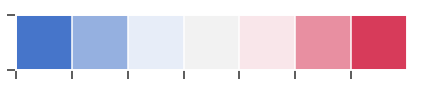

In [26]:
sns.palplot(sns.diverging_palette(255, 5, sep=80, n=7))

In [29]:
myp = sns.diverging_palette(255, 5, sep=80, n=2)

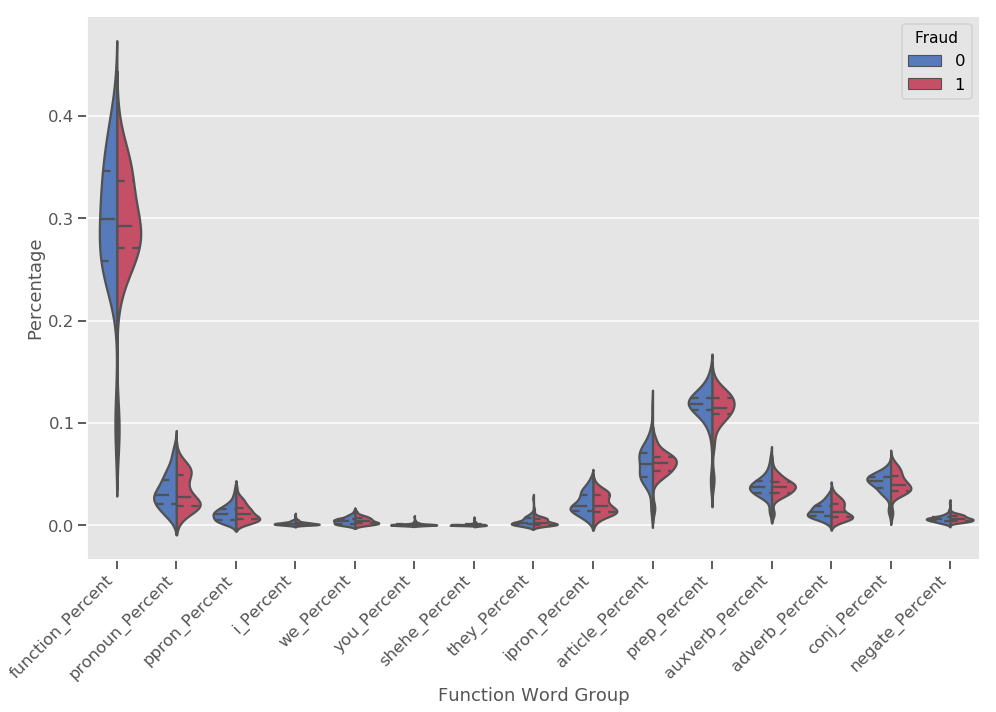

In [30]:
wf = data_fw.drop('File',axis=1).melt(var_name='Function Word Group', value_name='Percentage', id_vars='Fraud') # this is necessary for seaborn to work 

# plot violin
plt.figure(figsize=(16, 10))
fig = sns.violinplot(x="Function Word Group", y= "Percentage", hue="Fraud",
                    data= wf, palette=myp, split=True, inner = 'quartile')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45,horizontalalignment='right')

plt.show(fig)


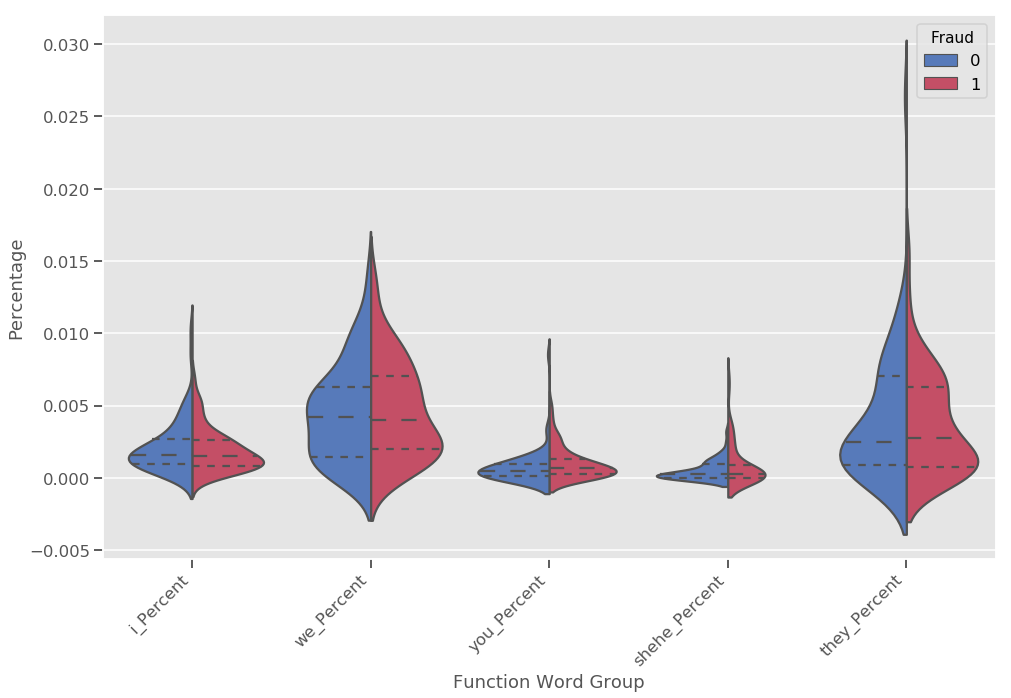

In [31]:
wf = data_fw.drop('File',axis=1).melt(var_name='Function Word Group', value_name='Percentage', id_vars='Fraud') # this is necessary for seaborn to work 

# plot violin
plt.figure(figsize=(16, 10))

isheheyouwethey = wf[wf['Function Word Group'].isin(['i_Percent','we_Percent', 'you_Percent', 'shehe_Percent','they_Percent'])]
                     
fig = sns.violinplot(x="Function Word Group", y= "Percentage", hue="Fraud",
                    data= isheheyouwethey, palette=myp, split=True,inner = 'quartile')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45,horizontalalignment='right')

plt.show(fig)

In [32]:
### Now the additional features 
add_f = data.drop('File',axis=1).melt(var_name='Feature', value_name='Z-Score', id_vars='Fraud') # this is necessary for seaborn to work 

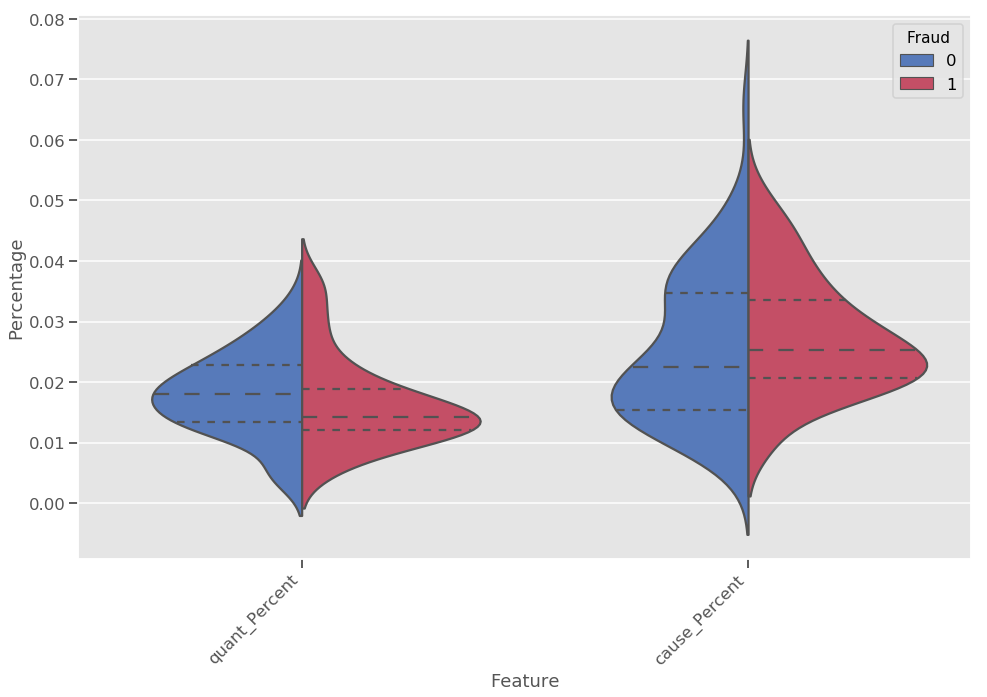

In [33]:
# 'quant_Percent', 'Detect_Percent', 'cause_Percent'
plt.figure(figsize=(16, 10))

quantCause = add_f[add_f['Feature'].isin(['quant_Percent', 'cause_Percent'])]
                     
fig = sns.violinplot(x='Feature', y= 'Z-Score', hue="Fraud",
                    data= quantCause, palette=myp, split=True,inner = 'quartile')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45,horizontalalignment='right') # change y value to Percentage
fig.set(xlabel='Feature', ylabel='Percentage')

plt.show(fig)

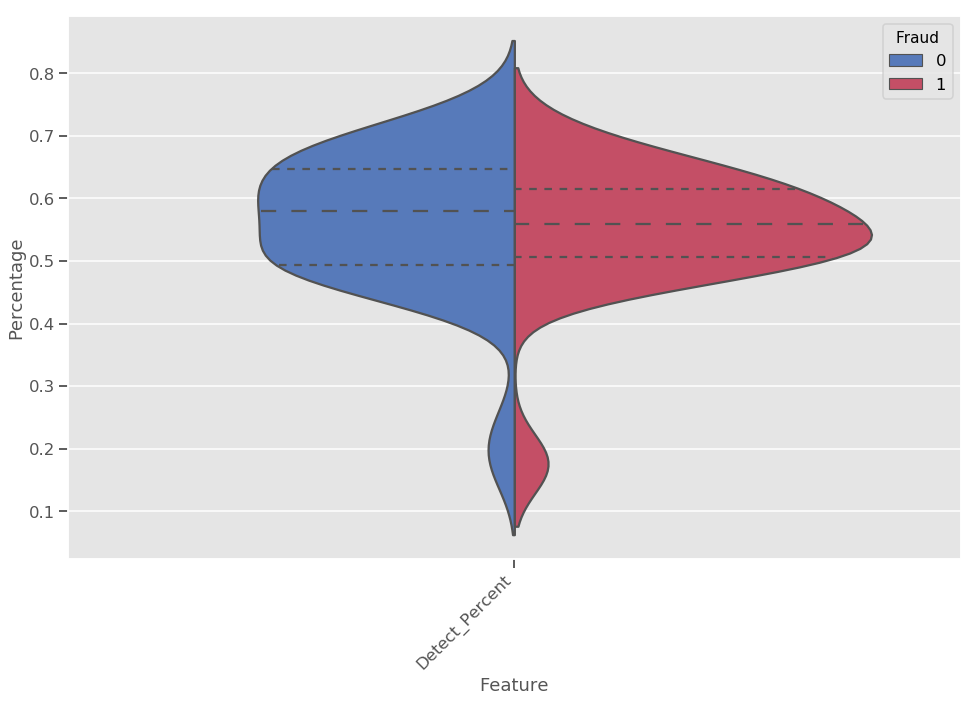

In [34]:
plt.figure(figsize=(16, 10))

detect = add_f[add_f['Feature'].isin(['Detect_Percent'])]
                     
fig = sns.violinplot(x='Feature', y= 'Z-Score', hue="Fraud",
                    data= detect, palette=myp, split=True,inner = 'quartile')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45,horizontalalignment='right') # change y value to Percentage
fig.set(xlabel='Feature', ylabel='Percentage')

plt.show(fig) 

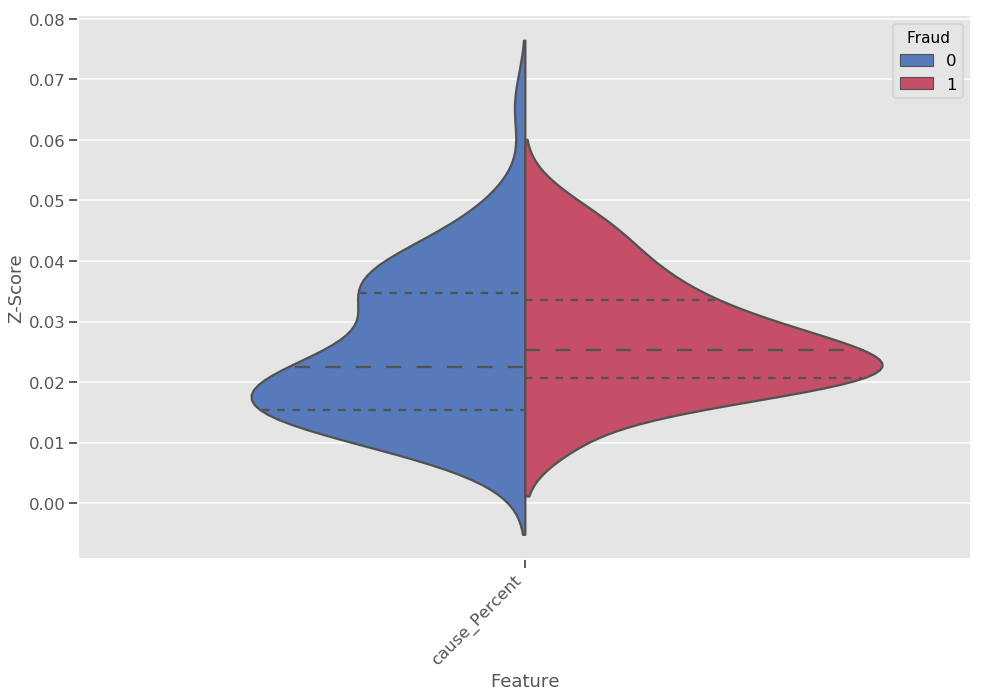

In [35]:
# 'quant_Percent', 'Detect_Percent', 'cause_Percent'
plt.figure(figsize=(16, 10))

quantDetectCause = add_f[add_f['Feature'].isin(['cause_Percent'])]
                     
fig = sns.violinplot(x='Feature', y= 'Z-Score', hue="Fraud",
                    data= quantDetectCause, palette=myp, split=True,inner = 'quartile')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45,horizontalalignment='right') # change y value to Percentage

plt.show(fig)

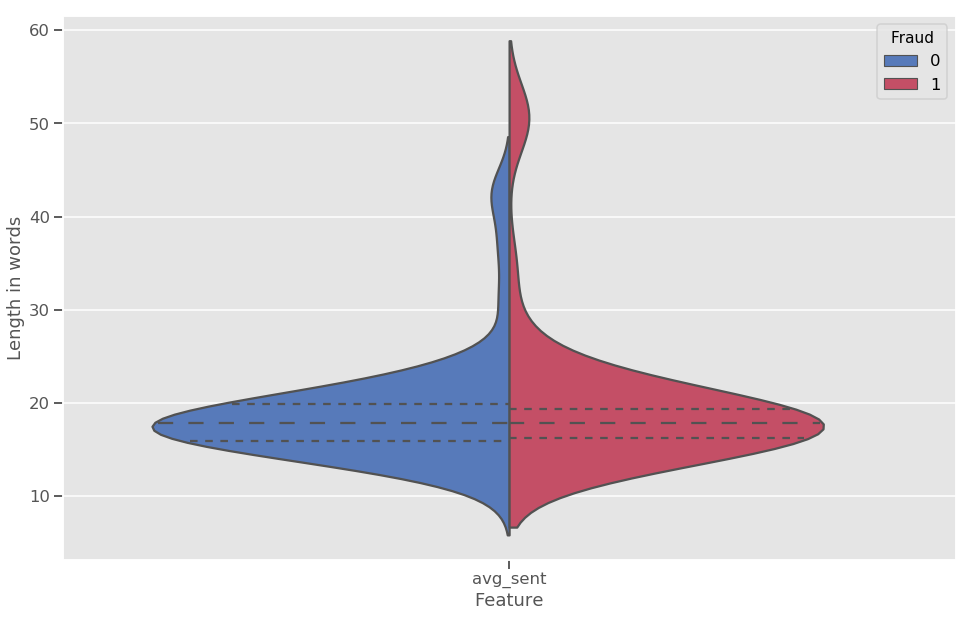

In [36]:
# 'average sentence length'
plt.figure(figsize=(16, 10))

unique = add_f[add_f['Feature'].isin(['avg_sent'])]
                     
fig = sns.violinplot(x='Feature', y= 'Z-Score', hue="Fraud",
                    data= unique, palette=myp, split=True,inner = 'quartile')
fig.set_xticklabels(fig.get_xticklabels()) # change y value to Percentage
fig.set(xlabel='Feature', ylabel='Length in words')

plt.show(fig)

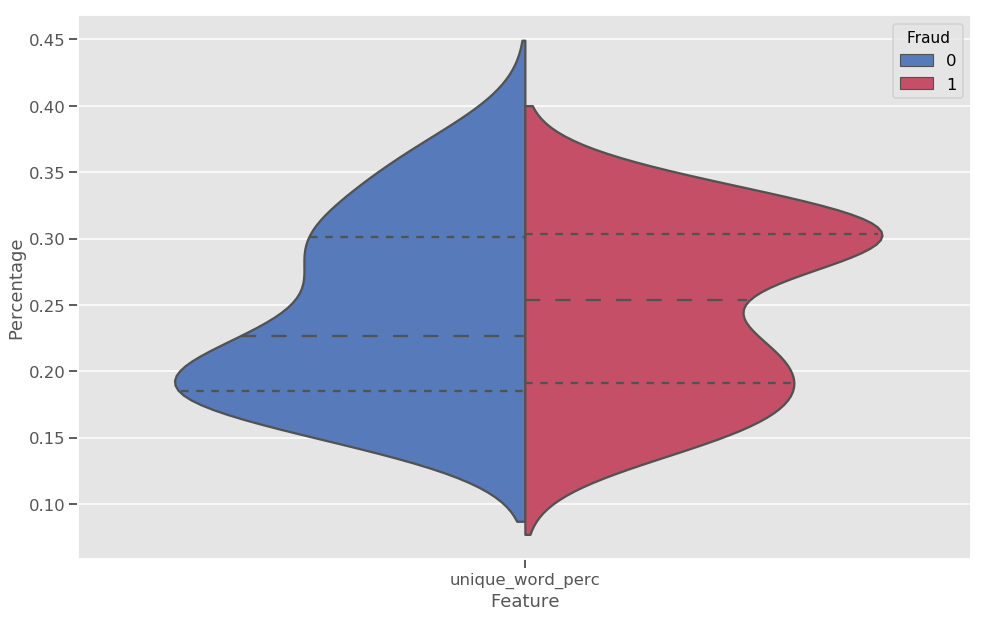

In [37]:
# 'unique_word_perc'
plt.figure(figsize=(16, 10))

unique = add_f[add_f['Feature'].isin(['unique_word_perc'])]
                     
fig = sns.violinplot(x='Feature', y= 'Z-Score', hue="Fraud",
                    data= unique, palette=myp, split=True,inner = 'quartile')
fig.set_xticklabels(fig.get_xticklabels()) # change y value to Percentage
fig.set(xlabel='Feature', ylabel='Percentage')

plt.show(fig)


In [38]:
X_s.columns

Index(['function_Percent', 'pronoun_Percent', 'ppron_Percent', 'i_Percent',
       'we_Percent', 'you_Percent', 'shehe_Percent', 'they_Percent',
       'ipron_Percent', 'article_Percent', 'prep_Percent', 'auxverb_Percent',
       'adverb_Percent', 'conj_Percent', 'negate_Percent', 'quant_Percent',
       'Detect_Percent', 'cause_Percent', 'posemo_Percent', 'avg_sent',
       'unique_word_perc', 'flesch_kincaid', 'vader_negative',
       'vader_positive', 'vader_neutral', 'vader_compound', 'jargon',
       'abstraction', 'posemo_Percent', 'obfuscation_index'],
      dtype='object')

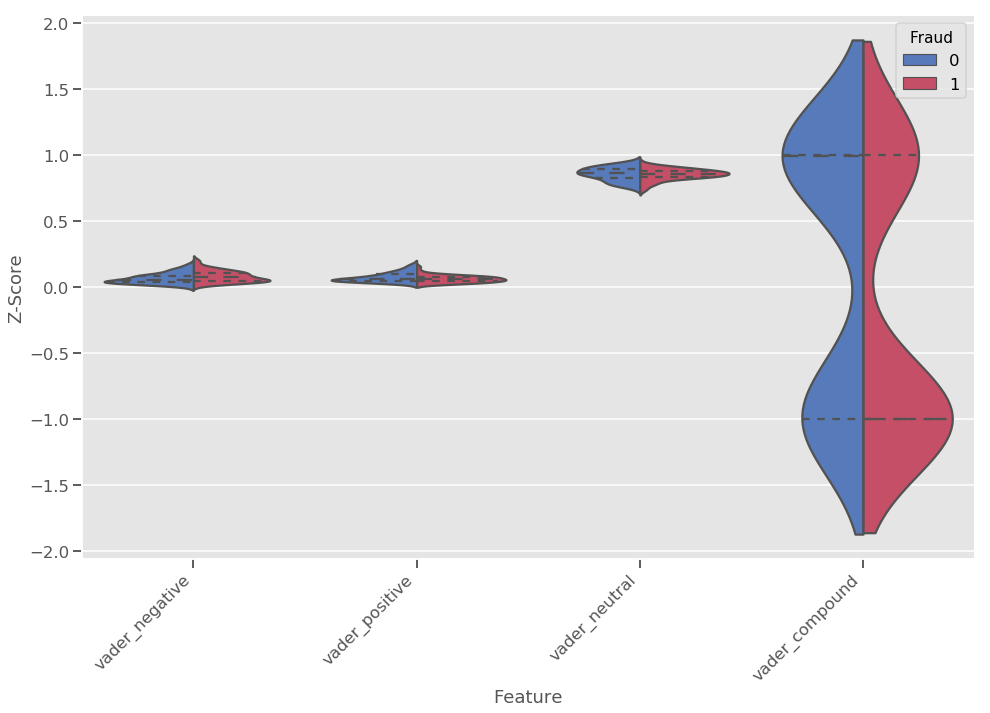

In [39]:
# vader pos neg compound 
plt.figure(figsize=(16, 10))

vader = add_f[add_f['Feature'].isin(['vader_negative', 'vader_positive', 'vader_neutral', 'vader_compound'])]
                     
fig = sns.violinplot(x='Feature', y= 'Z-Score', hue="Fraud",
                    data= vader, palette=myp, split=True,inner = 'quartile')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45,horizontalalignment='right') # change y value to Percentage

plt.show(fig)

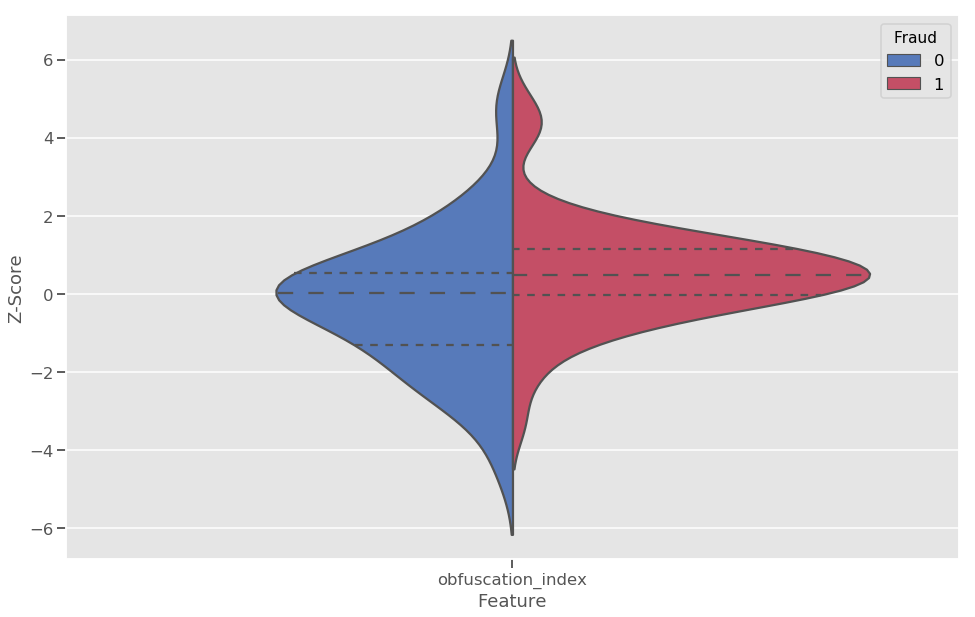

In [40]:
# obfuscation_index
plt.figure(figsize=(16, 10))

obfuscation = add_f[add_f['Feature'].isin(['obfuscation_index'])]
                     
fig = sns.violinplot(x='Feature', y= 'Z-Score', hue="Fraud",
                    data= obfuscation, palette=myp, split=True, inner = 'quartile')
fig.set_xticklabels(fig.get_xticklabels())

plt.show(fig)

In [41]:
summary_statistic = X.describe()
summary_statistic.to_csv("data_summary.csv", index=True)

In [42]:
summary_statistic

,function_Percent,pronoun_Percent,ppron_Percent,i_Percent,we_Percent,you_Percent,shehe_Percent,they_Percent,ipron_Percent,article_Percent,...,unique_word_perc,flesch_kincaid,vader_negative,vader_positive,vader_neutral,vader_compound,jargon,abstraction,posemo_Percent,obfuscation_index
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.294856,0.033364,0.012137,0.002060,0.004604,0.000892,0.000734,0.003853,0.021225,0.059568,...,0.245284,0.629208,0.074492,0.068633,0.856758,-0.046928,0.282112,0.096962,0.012977,0.155038
std,0.063035,0.016982,0.007915,0.001685,0.003310,0.001174,0.001178,0.003951,0.009976,0.016265,...,0.065358,0.129709,0.040911,0.031170,0.046023,0.997706,1.069987,1.219116,0.007662,1.620808
min,0.086983,0.005863,0.001466,0.000000,0.000000,0.000000,0.000000,0.000000,0.004124,0.013990,...,0.133136,0.411300,0.009000,0.022000,0.734000,-1.000000,-1.592231,-1.052126,0.002523,-4.568445
25%,0.267390,0.019268,0.005608,0.000878,0.001946,0.000203,0.000000,0.000778,0.013024,0.050595,...,0.188317,0.546775,0.042000,0.046750,0.829750,-0.999725,-0.393496,-0.368019,0.007456,-0.592593
50%,0.294267,0.029272,0.010657,0.001565,0.004197,0.000551,0.000273,0.002588,0.018789,0.060418,...,0.236209,0.617700,0.066500,0.061000,0.860000,-0.978500,0.202585,-0.196612,0.011218,0.225650
75%,0.340927,0.046958,0.016664,0.002652,0.006584,0.001113,0.000931,0.006440,0.030041,0.069071,...,0.302298,0.662400,0.101250,0.082250,0.889000,0.999800,0.791713,0.007158,0.016311,1.017432
max,0.414341,0.077605,0.036525,0.010299,0.014117,0.008528,0.006987,0.026375,0.045512,0.115604,...,0.389914,1.113100,0.199000,0.171000,0.943000,1.000000,3.997940,6.156402,0.045993,4.909360


In [44]:
summary_statistic.columns

Index(['function_Percent', 'pronoun_Percent', 'ppron_Percent', 'i_Percent',
       'we_Percent', 'you_Percent', 'shehe_Percent', 'they_Percent',
       'ipron_Percent', 'article_Percent', 'prep_Percent', 'auxverb_Percent',
       'adverb_Percent', 'conj_Percent', 'negate_Percent', 'quant_Percent',
       'Detect_Percent', 'cause_Percent', 'posemo_Percent', 'avg_sent',
       'unique_word_perc', 'flesch_kincaid', 'vader_negative',
       'vader_positive', 'vader_neutral', 'vader_compound', 'jargon',
       'abstraction', 'posemo_Percent', 'obfuscation_index'],
      dtype='object')

In [45]:
summary_statistic['avg_sent']

count    120.000000
mean      19.507824
std        6.949556
min       11.079310
25%       16.055217
50%       17.890805
75%       19.873673
max       51.915344
Name: avg_sent, dtype: float64

In [23]:
# Kolgomorov Smirnov Test for distributions 
from scipy import stats

sig_count = 0
non_sig_count = 0

summary = pd.DataFrame(columns = ['feature', 'statistic', 'p_value'])

for feature in X.columns: 
    case_distribution = X_s[(Y == 1).values][feature]
    control_distribution = X_s[(Y == 0).values][feature]
    stat, p_value = stats.ks_2samp(case_distribution, control_distribution)
    if float(p_value) < 0.05: 
        print("For " + str(feature) + " p_value = " + str(round(p_value,3)) + " IS sign." + " And stat: " + str(round(stat,3)))
        sig_count += 1
        summary = summary.append({'feature':str(feature),'p_value':str(round(p_value,3)), 'statistic':str(round(stat,3))}, ignore_index = True) 
    else: 
        print("For " + str(feature) + " p_value = " + str(round(p_value,3)) + " is not sign." + " And stat: " + str(round(stat,3)))
        non_sig_count += 1
        summary = summary.append({'feature':str(feature),'p_value':str(round(p_value,3)), 'statistic':str(round(stat,3))}, ignore_index = True) 
print(summary)
        

For function_Percent p_value = 0.629 is not sign. And stat: 0.133
For pronoun_Percent p_value = 0.345 is not sign. And stat: 0.167
For ppron_Percent p_value = 0.911 is not sign. And stat: 0.1
For i_Percent p_value = 0.784 is not sign. And stat: 0.117
For we_Percent p_value = 0.911 is not sign. And stat: 0.1
For you_Percent p_value = 0.345 is not sign. And stat: 0.167
For shehe_Percent p_value = 0.239 is not sign. And stat: 0.183
For they_Percent p_value = 0.784 is not sign. And stat: 0.117
For ipron_Percent p_value = 0.784 is not sign. And stat: 0.117
For article_Percent p_value = 0.103 is not sign. And stat: 0.217
For prep_Percent p_value = 0.16 is not sign. And stat: 0.2
For auxverb_Percent p_value = 0.999 is not sign. And stat: 0.067
For adverb_Percent p_value = 0.345 is not sign. And stat: 0.167
For conj_Percent p_value = 0.103 is not sign. And stat: 0.217
For negate_Percent p_value = 0.784 is not sign. And stat: 0.117
For quant_Percent p_value = 0.039 IS sign. And stat: 0.25
For D

In [24]:
from scipy.stats import mannwhitneyu

sig_count = 0
non_sig_count = 0

summary = pd.DataFrame(columns = ['feature', 'statistic', 'p_value'])

for feature in X.columns: 
    case_distribution = X_s[(Y == 1).values][feature]
    control_distribution = X_s[(Y == 0).values][feature]
    stat, p_value = mannwhitneyu(case_distribution, control_distribution)
    if float(p_value) < 0.05: 
        print("For " + str(feature) + " p_value = " + str(p_value) + " IS sign.")
        sig_count += 1
        summary = summary.append({'feature':str(feature),'p_value':str(round(p_value,3)), 'statistic':str(round(stat,3))}, ignore_index = True) 

    else: 
        print("For " + str(feature) + " p_value = " + str(p_value) + " is NOT sign.")
        non_sig_count += 1
        summary = summary.append({'feature':str(feature),'p_value':str(round(p_value,3)), 'statistic':str(round(stat,3))}, ignore_index = True) 

print(summary)

For function_Percent p_value = 0.31366088012301824 is NOT sign.
For pronoun_Percent p_value = 0.3754157329102822 is NOT sign.
For ppron_Percent p_value = 0.4717558838619505 is NOT sign.
For i_Percent p_value = 0.26525967152090746 is NOT sign.
For we_Percent p_value = 0.4158305168202999 is NOT sign.
For you_Percent p_value = 0.040583155467777174 IS sign.
For shehe_Percent p_value = 0.37734811500246135 is NOT sign.
For they_Percent p_value = 0.36944578575660186 is NOT sign.
For ipron_Percent p_value = 0.2971075603257688 is NOT sign.
For article_Percent p_value = 0.492671735675603 is NOT sign.
For prep_Percent p_value = 0.15868733424659998 is NOT sign.
For auxverb_Percent p_value = 0.4322765967567417 is NOT sign.
For adverb_Percent p_value = 0.4015601980581248 is NOT sign.
For conj_Percent p_value = 0.19977981059938377 is NOT sign.
For negate_Percent p_value = 0.28451579659534026 is NOT sign.
For quant_Percent p_value = 0.02753137086865075 IS sign.
For Detect_Percent p_value = 0.241746845

### Unsupervised learning

In [90]:
# kmeans with nclusters 2 
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

kmeans = KMeans(n_clusters=2, random_state=42).fit(X_s)
kmeans.labels_[0:10]

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0], dtype=int32)

In [91]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([64, 56]))

In [96]:
print( 1 - accuracy_score(data_fw['Fraud'],kmeans.labels_))

0.4916666666666667


In [93]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set_style("darkgrid")

In [94]:
sns.__version__

'0.9.0'

[0.45560928 0.1543342 ]


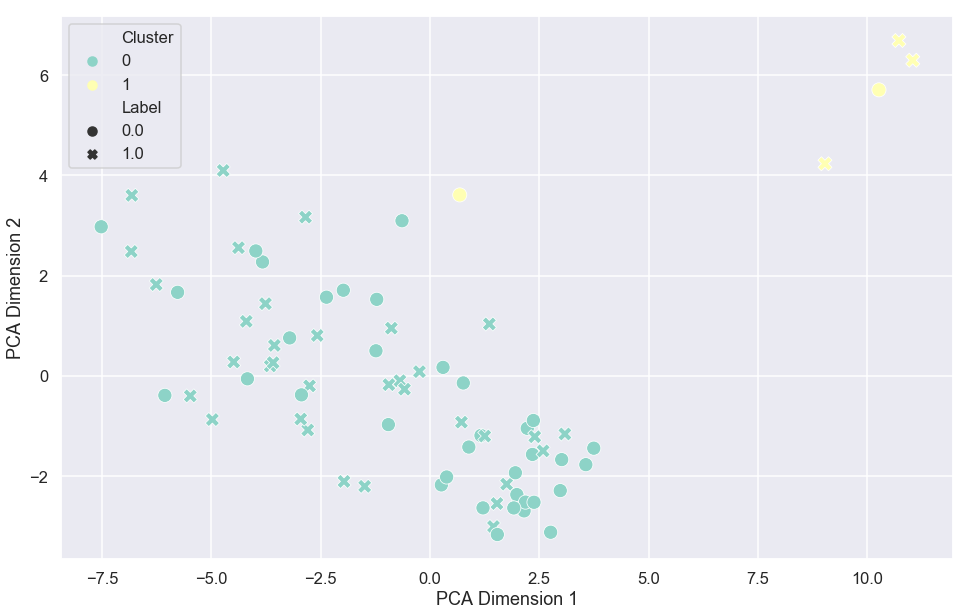

In [95]:
# visualize k means with pca 
from sklearn.decomposition import PCA

# pca 
pca = PCA(n_components=2)
pca_embedded = pca.fit_transform(X_s)
pca_df = pd.DataFrame(data = pca_embedded, 
        columns = ['PCA Dimension 1', 'PCA Dimension 2'])
print(pca.explained_variance_ratio_)

kmeans = KMeans(n_clusters=2, random_state=42).fit(X)

pca_df['Cluster'] = kmeans.labels_
pca_df['Label'] = data['Fraud']

plt.figure(figsize=(16, 10))

sns.scatterplot(x="PCA Dimension 1", y="PCA Dimension 2",
                hue="Cluster", style="Label",
                data=pca_df, palette="Set3",s=200)

In [27]:
## Hiearchical Clustering 

In [97]:
import scipy 
from scipy.cluster.hierarchy import dendrogram, linkage 
from scipy.cluster.hierarchy import fcluster 
from scipy.cluster.hierarchy import cophenet 
from scipy.spatial.distance import pdist

from pylab import rcParams
import seaborn as sns 
import matplotlib.pyplot as plt 

import sklearn 
from sklearn.cluster import AgglomerativeClustering 
import sklearn.metrics as sm 


In [98]:
# generating hclusters 
k = 2 

affinities = ['euclidean', 'manhattan', 'cosine', "l1", "l2"]
linkages = ['ward', 'complete', 'average', 'single']

for a in affinities: 
    for l in linkages: 
        try:
            Hclustering = AgglomerativeClustering(n_clusters = k, affinity = a, linkage = l)
            Hclustering.fit(X_s)
            print("Accuracy for " + str(a) + " & " + str(l) + " is " + str(sm.accuracy_score(Y,Hclustering.labels_)))
        except: 
            pass
        

Accuracy for euclidean & ward is 0.475
Accuracy for euclidean & complete is 0.5
Accuracy for euclidean & average is 0.5
Accuracy for euclidean & single is 0.5
Accuracy for manhattan & complete is 0.5
Accuracy for manhattan & average is 0.5
Accuracy for manhattan & single is 0.5
Accuracy for cosine & complete is 0.5083333333333333
Accuracy for cosine & average is 0.5166666666666667
Accuracy for cosine & single is 0.5083333333333333
Accuracy for l1 & complete is 0.5
Accuracy for l1 & average is 0.5
Accuracy for l1 & single is 0.5
Accuracy for l2 & complete is 0.5
Accuracy for l2 & average is 0.5
Accuracy for l2 & single is 0.5


In [364]:
Hclustering = AgglomerativeClustering(n_clusters = 2, affinity = "cosine", linkage = "complete")
Hclustering.fit(X)
sum(Hclustering.labels_)

101

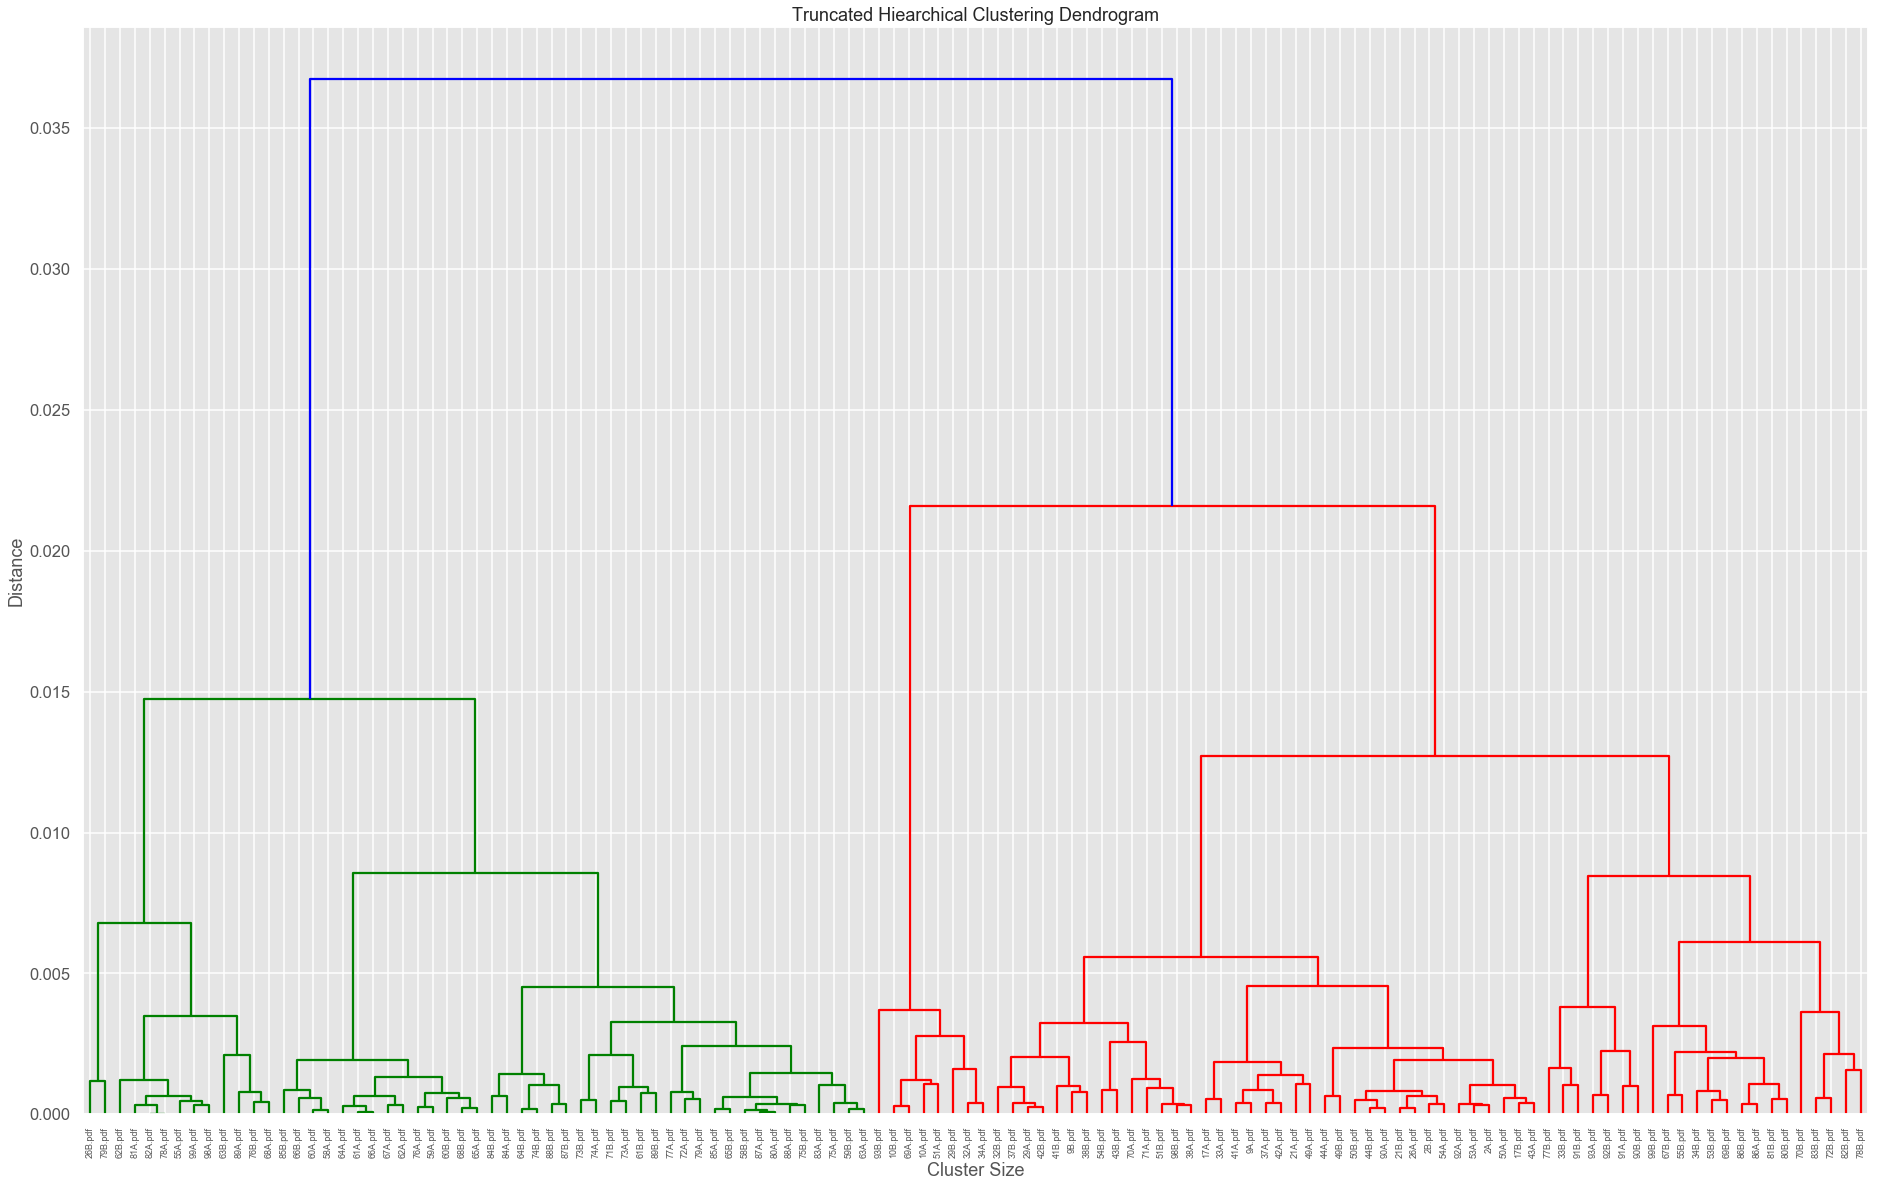

In [218]:
plt.figure(figsize=(32,20))

Z = linkage(X, method='complete', metric='cosine')
dendro = dendrogram(Z, leaf_font_size = 9., labels=X.index,get_leaves=True)
plt.title('Truncated Hiearchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show(dendro)


In [204]:
# quick test --> http://www.nxn.se/valent/extract-cluster-elements-by-color-in-python

In [205]:
from collections import defaultdict

import pandas as pd
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
#from fastcluster import linkage
import seaborn as sns
from matplotlib.colors import rgb2hex, colorConverter

In [206]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

In [207]:
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes


In [208]:
get_cluster_classes(dendro)

g,"['26B.pdf', '79B.pdf', '82A.pdf', '78A.pdf', '81A.pdf', '99A.pdf', '98A.pdf', '55A.pdf', '62B.pdf', '76B.pdf', '68A.pdf', '89A.pdf', '63B.pdf', '60A.pdf', '58A.pdf', '66B.pdf', '85B.pdf', '61A.pdf', '66A.pdf', '64A.pdf', '67A.pdf', '62A.pdf', '76A.pdf', '59A.pdf', '68B.pdf', '65A.pdf', '60B.pdf', '84B.pdf', '84A.pdf', '64B.pdf', '74B.pdf', '88B.pdf', '87B.pdf', '73B.pdf', '74A.pdf', '71B.pdf', '73A.pdf', '61B.pdf', '89B.pdf', '72A.pdf', '79A.pdf', '77A.pdf', '85A.pdf', '65B.pdf', '87A.pdf', '80A.pdf', '58B.pdf', '88A.pdf', '75B.pdf', '59B.pdf', '63A.pdf', '75A.pdf', '83A.pdf', '71B.pdf', '64B.pdf']"
r,"['10B.pdf', '69A.pdf', '10A.pdf', '51A.pdf', '32A.pdf', '34A.pdf', '29B.pdf', '93B.pdf', '29A.pdf', '42B.pdf', '37B.pdf', '32B.pdf', '9B.pdf', '38B.pdf', '41B.pdf', '54B.pdf', '43B.pdf', '98B.pdf', '38A.pdf', '51B.pdf', '71A.pdf', '70A.pdf', '17A.pdf', '33A.pdf', '41A.pdf', '9A.pdf', '37A.pdf', '42A.pdf', '21A.pdf', '49A.pdf', '42A.pdf', '44A.pdf', '49B.pdf', '44B.pdf', '90A.pdf', '50B.pdf', '21B.pdf', '26A.pdf', '2B.pdf', '54A.pdf', '53A.pdf', '2A.pdf', '92A.pdf', '17B.pdf', '43A.pdf', '50A.pdf', '33B.pdf', '91B.pdf', '77B.pdf', '93A.pdf', '92B.pdf', '91A.pdf', '90B.pdf', '67B.pdf', '55B.pdf', '53B.pdf', '69B.pdf', '34B.pdf', '86B.pdf', '86A.pdf', '81B.pdf', '80B.pdf', '99B.pdf', '83B.pdf', '72B.pdf', '82B.pdf', '78B.pdf', '70B.pdf']"


In [213]:
120-68

52

In [165]:
print(dendro['leaves'])
print(dendro['ivl'])

[196, 198, 108, 177, 208, 202, 158, 185, 176, 203, 34, 197, 205, 186, 188, 183, 199, 207, 171, 209, 206, 173, 187, 12, 172, 179, 195, 29, 164, 204]
['(2)', '(7)', '63B.pdf', '(3)', '(14)', '(6)', '(2)', '(4)', '(3)', '(11)', '93B.pdf', '(4)', '(3)', '(4)', '(3)', '(2)', '(5)', '(8)', '(2)', '(13)', '(3)', '(2)', '(2)', '99B.pdf', '(2)', '(3)', '(4)', '70B.pdf', '(2)', '(2)']


In [32]:
Z.shape

(119, 4)

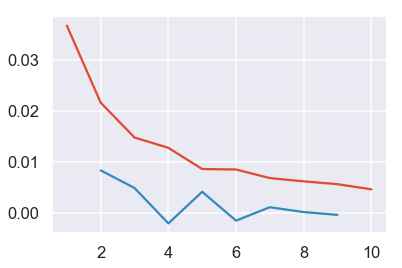

clusters: 2


In [33]:
last = Z[-10:, 2] # why these values
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [34]:
from scipy.cluster.hierarchy import leaves_list
print(leaves_list(Z))

[ 44 118  97  98  17  95 102   5  20 108  33  11  57  31  26   3  92  63
  21  32  39  89   4 112  10  65  74  41  49  55  94  48  64  85  86  45
  76  16  27  19  61 109  25  83 100  56 107  40 110   9 119 103 117  34
  42  82  50  51  60  70 115  79   8  52  91  23  96 114  93 113  35  37
  43  15 105   7  66  18  88   1  99   6  69  59  78  30  67  84  13  36
  72 101  46  77  81  24   0 104  14  58  62  28  38  54  75  12  47 111
 106  68  73  71  80  90 116  29   2  53  22  87]


In [161]:
X.index

Index(['17B.pdf', '37A.pdf', '83B.pdf', '60A.pdf', '76A.pdf', '99A.pdf',
       '21A.pdf', '17A.pdf', '37B.pdf', '83A.pdf',
       ...
       '75B.pdf', '55B.pdf', '59A.pdf', '43B.pdf', '38B.pdf', '34A.pdf',
       '80B.pdf', '63A.pdf', '79B.pdf', '75A.pdf'],
      dtype='object', name='File', length=120)

In [35]:
leaves_list(Z)[0]

44

In [36]:
Hclustering = AgglomerativeClustering(n_clusters = k, affinity = 'cosine', linkage = 'complete')
Hclustering.fit(X)
y_pred = Hclustering.labels_

In [37]:
Hclustering.n_leaves_

120

In [38]:
# let's see if the grouping of the texts reveals some linguistic similiarity based on journals topic etc 

# 37A.pdf ->
# 21A.pdf -> 
# 41A.pdf -> 
# 93B.pdf -> 
# 10B.pdf -> 
# 10A.pdf -> 
# 51A.pdf -> 
# 29B.pdf -> 
# 49A.pdf -> 
# 32A.pdf -> 
# 69A.pdf -> 
# 9A.pdf -> 
# 42A.pdf -> 
# 34A.pdf -> group on its own 

In [39]:
# make splits 

In [108]:
### 3.1) Leave one out Cross-Validation with case control design
import random

def cross_validation_cc(df, k=5, seed=42): 
    '''
    df: dataframe with file column names A and B for A being the case group and B being the control group 
    k: number of splits, number of cases must be divisible by k 
    returns list of list of cases
    '''
    if len(df) % k != 0:
        print("Choose a k that number of cases can be divided by ...")
        
    # get cases list 
    cases = [c for c in df.File if "A" in c]
    
    # set random seed
    random.seed(seed)
    
    # shuffle cases randomly 
    cases = random.sample(cases, len(cases))

    # match with control 
    control = [re.sub('A', 'B', c) for c in cases] 

    cc_lists = [] 
    number_per_split = len(df) / k # sum of case and control
    
    index = 0
    for split in range(1,k+1): 
        cc_lists.append( cases[index:int(index + (number_per_split/2))] + control[index:int(index + (number_per_split/2))])
        index = int(index + number_per_split/2)
    return(cc_lists)

def get_train_test(df, X, split):
    cross_val_filter = df.File.isin(split).values
    X_train = X[~cross_val_filter]
    X_test = X[cross_val_filter]
    Y_train = Y[~cross_val_filter]
    Y_test = Y[cross_val_filter]
    return X_train,Y_train,X_test,Y_test

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# logistic regression
parameters = {'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver': ['liblinear'],
              'max_iter' : [10000]
              }

LR = LogisticRegression()
clf_LR = GridSearchCV(LR, parameters, cv=5)
clf_LR.fit(X.reset_index().drop('File',axis=1),Y)
print(clf_LR.best_estimator_)
print(clf_LR.best_score_)



from sklearn import tree

# decision tree 
parameters = {'max_depth': np.arange(3, 10),
              'min_samples_split': np.arange(2, 10),
              }
DT = tree.DecisionTreeClassifier()
clf_DT = GridSearchCV(DT, parameters, cv=5)
clf_DT.fit(X.reset_index().drop('File',axis=1),Y)
print(clf_DT.best_estimator_)
print(clf_DT.best_score_)


from sklearn.ensemble import RandomForestClassifier

# random forest 
parameters = {'max_depth': np.arange(3, 10),
             'min_samples_leaf': [2, 5],
             'min_samples_split': [2, 5],
             'n_estimators': [10, 20, 50, 100]
              }

RF = RandomForestClassifier()
clf_RF = GridSearchCV(RF, parameters, cv=5)
clf_RF.fit(X.reset_index().drop('File',axis=1),Y)
print(clf_RF.best_estimator_)
print(clf_RF.best_score_)


in order to obtain a good estimate for the three models I will use the custom CV, save the results and repeat the procedure with multiple Random seeds

## Look at cross correlations in the data 

In [25]:
X_s_to_corr = X_s.copy()
X_s_to_corr['Fraud'] = Y.values

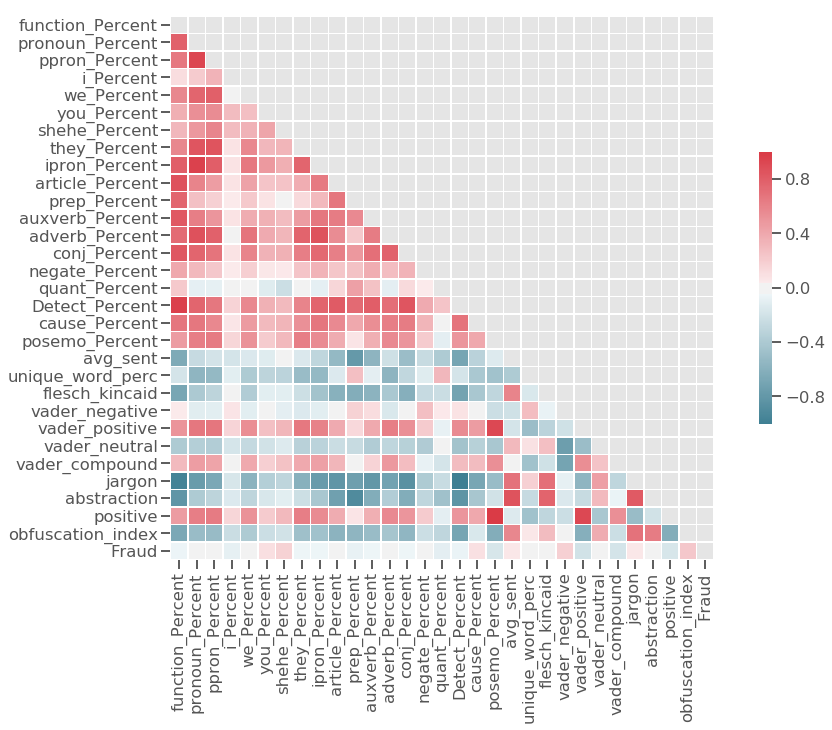

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = X_s_to_corr.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize=(16, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [46]:
corr = np.around(corr, decimals=3) 

In [48]:
corr.to_csv('correlation_matrix.csv')

In [41]:
from scipy.stats import pearsonr

sig_count = 0
non_sig_count = 0

summary = pd.DataFrame(columns = ['feature', 'correlation', 'p_value'])

for c in X_s.columns: 
    r_row, p_value = pearsonr(X_s_to_corr[c],  X_s_to_corr['Fraud'])    
    if float(p_value) < 0.05: 
        print("For " + str(c) + " p_value = " + str(p_value) + " IS sign.")
        sig_count += 1
        summary = summary.append({'feature':str(c),'p_value':str(round(p_value,3)), 'correlation':str(round(r_row,3))}, ignore_index = True) 

    else: 
        #print("For " + str(c) + " p_value = " + str(p_value) + " is NOT sign.")
        non_sig_count += 1
        summary = summary.append({'feature':str(c),'p_value':str(round(p_value,3)), 'correlation':str(round(r_row,3))}, ignore_index = True) 

print(summary)

For vader_negative p_value = 0.046840773847126906 IS sign.
For vader_positive p_value = 0.028286107603270137 IS sign.
For vader_compound p_value = 0.04126608659761942 IS sign.
For obfuscation_index p_value = 0.012447472560554573 IS sign.
              feature correlation p_value
0    function_Percent      -0.049   0.597
1     pronoun_Percent      -0.021   0.822
2       ppron_Percent       0.011   0.901
3           i_Percent      -0.081   0.382
4          we_Percent       0.017   0.851
5         you_Percent       0.109   0.236
6       shehe_Percent       0.174   0.058
7        they_Percent      -0.042   0.651
8       ipron_Percent      -0.045   0.628
9     article_Percent      -0.021    0.82
10       prep_Percent      -0.078   0.397
11    auxverb_Percent      -0.042   0.646
12     adverb_Percent       0.024   0.793
13       conj_Percent      -0.043   0.644
14     negate_Percent       0.014   0.883
15      quant_Percent        -0.1   0.278
16     Detect_Percent      -0.062   0.499
17    

In [ ]:
#sns.pairplot(X_s_to_corr, hue ="Fraud")

/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in r

### Function words only 

In [128]:
#Function words only 
X_s_fw = X_s[['function_Percent',
             'pronoun_Percent', 
             'ppron_Percent', 
             'i_Percent', 
             'we_Percent',
             'you_Percent', 
             'shehe_Percent', 
             'they_Percent', 
             'ipron_Percent',
             'article_Percent', 
             'prep_Percent', 
             'auxverb_Percent', 
             'adverb_Percent',
             'conj_Percent',
             'negate_Percent']]

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm 

seeds = [1,2,3,4,5,6,7,8,9,10]

results = pd.DataFrame(columns = ['classifier', 'accuracy', 'sensitivity' , 'specificity', 'auc', 'split', 'seed'])


for seed in tqdm(seeds): 
    # record all the accuracies etc for this seed 
    seed_results = pd.DataFrame(columns = ['classifier', 'accuracy', 'sensitivity' , 'specificity', 'auc', 'split', 'seed'])
    
    # get a new split list 
    split_list = cross_validation_cc(data, 5,seed)
    
    for split in split_list:
        # get new train and test sets 
        (X_train,Y_train,X_test,Y_test) = get_train_test(data,X_s_fw, split)

        # initialize and fit each unsupervised classifier 
        kmeans_clf = KMeans(n_clusters=2, random_state=42).fit(X_test)
        Hclustering_clf = AgglomerativeClustering(n_clusters = 2, affinity = "cosine", linkage = "complete").fit(X_test)
        
        # initialize each supervised classifier 
        LR_clf = LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

        DT_clf = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

        RF_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0,
            warm_start=False)
        
        # fit on data 
        LR_clf.fit(X_train, Y_train)
        DT_clf.fit(X_train, Y_train)
        RF_clf.fit(X_train, Y_train)
        
        supervised_classifiers = [LR_clf,DT_clf,RF_clf]
        unsupervised_classifiers = [kmeans_clf, Hclustering_clf]
        
        for sclf in supervised_classifiers: 
            # evaluate the results 
            yhat = sclf.predict(X_test)
            acc = accuracy_score(Y_test, yhat) 
            tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
            fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat, pos_label=1)
            sens = (tp/(tp +fn))
            spec = (tn/(tn+ fp))
            auc = metrics.auc(fpr, tpr)
        
            # save results in dictionary
            seed_dict = {'classifier': str(sclf),
                         'accuracy':acc, 
                         'sensitivity': sens, 
                         'specificity': spec, 
                         'auc': auc,
                         'split': split, 
                         'seed': seed
            
            }
        
            # append dictionary to dataframe 
            seed_results = seed_results.append(seed_dict, ignore_index = True)
        
        for uclf in unsupervised_classifiers: 
            # evaluate the results 
            yhat = uclf.labels_
            acc = accuracy_score(Y_test, yhat) 
            tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
            fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat, pos_label=1)
            sens = (tp/(tp +fn))
            spec = (tn/(tn+ fp))
            auc = metrics.auc(fpr, tpr)
        
            # save results in dictionary
            seed_dict = {'classifier': str(uclf),
                         'accuracy':acc, 
                         'sensitivity': sens, 
                         'specificity': spec, 
                         'auc': auc,
                         'split': split, 
                         'seed': seed
            
            }
        
            # append dictionary to dataframe 
            seed_results = seed_results.append(seed_dict, ignore_index = True)
    
# append to seed results to final results 
results = results.append(seed_results, ignore_index = True)   
    
aggregation = {
    'accuracy' : {'mean', 'std'},
    'sensitivity': {'mean', 'std'},
    'specificity': {'mean', 'std'},
    'auc' : {'mean', 'std'}
}

results_aggregated = results.groupby('classifier',as_index=False).agg(aggregation)
conversion_dict = {
                   "AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',\n            connectivity=None, linkage='complete', memory=None,\n            n_clusters=2, pooling_func='deprecated')": "Agglomerative Clustering", 
                   "DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,\n            max_features=None, max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, presort=False, random_state=None,\n            splitter='best')": "Decision Tree", 
                   "KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,\n    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',\n    random_state=42, tol=0.0001, verbose=0)":"K-Means", 
                   "LogisticRegression(C=10000.0, class_weight=None, dual=False,\n          fit_intercept=True, intercept_scaling=1, max_iter=10000,\n          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,\n          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)": "Logistic Regression", 
                   "RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n            max_depth=4, max_features='auto', max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=2, min_samples_split=10,\n            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,\n            oob_score=False, random_state=None, verbose=0,\n            warm_start=False)": "Random Forest"
                  }
results_aggregated['classifier'] = results_aggregated['classifier'].replace(conversion_dict)
results_aggregated  




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:25<03:52, 25.83s/it]


 20%|██        | 2/10 [00:46<03:13, 24.17s/it]


 30%|███       | 3/10 [01:12<02:53, 24.86s/it]


 40%|████      | 4/10 [01:34<02:23, 23.96s/it]


 50%|█████     | 5/10 [01:58<02:00, 24.10s/it]


 60%|██████    | 6/10 [02:26<01:41, 25.31s/it]


 70%|███████   | 7/10 [03:14<01:36, 32.05s/it]


 80%|████████  | 8/10 [03:38<00:59, 29.70s/it]


 90%|█████████ | 9/10 [04:02<00:27, 27.85s/it]


100%|██████████| 10/10 [04:20<00:00, 25.01s/it]

classifier sensitivity            \
                                                            mean       std   
0                           Agglomerative Clustering    0.416667  0.144338   
1  DecisionTreeClassifier(class_weight=None, crit...    0.550000  0.172804   
2                                            K-Means    0.366667  0.209165   
3  LogisticRegression(C=10000.0, class_weight=Non...    0.583333  0.204124   
4  RandomForestClassifier(bootstrap=True, class_w...    0.666667  0.144338   

   accuracy                 auc           specificity            
       mean       std      mean       std        mean       std  
0  0.483333  0.047507  0.483333  0.047507    0.550000  0.162447  
1  0.583333  0.088388  0.583333  0.088388    0.616667  0.095015  
2  0.500000  0.029463  0.500000  0.029463    0.633333  0.172804  
3  0.550000  0.103749  0.550000  0.103749    0.516667  0.123603  
4  0.633333  0.061802  0.633333  0.061802    0.600000  0.069722

In [135]:
len(results['split'][0])

24

In [124]:
X_s.columns

Index(['function_Percent', 'pronoun_Percent', 'ppron_Percent', 'i_Percent',
       'we_Percent', 'you_Percent', 'shehe_Percent', 'they_Percent',
       'ipron_Percent', 'article_Percent', 'prep_Percent', 'auxverb_Percent',
       'adverb_Percent', 'conj_Percent', 'negate_Percent', 'quant_Percent',
       'Detect_Percent', 'cause_Percent', 'posemo_Percent', 'avg_sent',
       'unique_word_perc', 'flesch_kincaid', 'vader_negative',
       'vader_positive', 'vader_neutral', 'vader_compound', 'jargon',
       'abstraction', 'positive', 'obfuscation_index'],
      dtype='object')

### All features 


In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

seeds = [1,2,3,4,5,6,7,8,9,10]

results = pd.DataFrame(columns = ['classifier', 'accuracy', 'sensitivity' , 'specificity', 'auc', 'split', 'seed'])


for seed in tqdm(seeds): 
    # record all the accuracies etc for this seed 
    seed_results = pd.DataFrame(columns = ['classifier', 'accuracy', 'sensitivity' , 'specificity', 'auc', 'split', 'seed'])
    
    # get a new split list 
    split_list = cross_validation_cc(data, 5,seed)
    
    for split in split_list:
        # get new train and test sets 
        (X_train,Y_train,X_test,Y_test) = get_train_test(data,X_s, split)
        
        # initialize and fit each unsupervised classifier 
        kmeans_clf = KMeans(n_clusters=2, random_state=42).fit(X_test)
        Hclustering_clf = AgglomerativeClustering(n_clusters = 2, affinity = "cosine", linkage = "complete").fit(X_test)
        
        # initialize each supervised classifier 
        LR_clf = LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

        DT_clf = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

        RF_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0,
            warm_start=False)
        
        # fit on data 
        LR_clf.fit(X_train, Y_train)
        DT_clf.fit(X_train, Y_train)
        RF_clf.fit(X_train, Y_train)
        
        supervised_classifiers = [LR_clf,DT_clf,RF_clf]
        unsupervised_classifiers = [kmeans_clf, Hclustering_clf]
        
        for sclf in supervised_classifiers: 
            # evaluate the results 
            yhat = sclf.predict(X_test)
            acc = accuracy_score(Y_test, yhat) 
            tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
            fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat, pos_label=1)
            sens = (tp/(tp +fn))
            spec = (tn/(tn+ fp))
            auc = metrics.auc(fpr, tpr)
        
            # save results in dictionary
            seed_dict = {'classifier': str(sclf),
                         'accuracy':acc, 
                         'sensitivity': sens, 
                         'specificity': spec, 
                         'auc': auc,
                         'split': split, 
                         'seed': seed
            
            }
        
            # append dictionary to dataframe 
            seed_results = seed_results.append(seed_dict, ignore_index = True)
        
        for uclf in unsupervised_classifiers: 
            # evaluate the results 
            yhat = uclf.labels_
            acc = accuracy_score(Y_test, yhat) 
            tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
            fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat, pos_label=1)
            sens = (tp/(tp +fn))
            spec = (tn/(tn+ fp))
            auc = metrics.auc(fpr, tpr)
        
            # save results in dictionary
            seed_dict = {'classifier': str(uclf),
                         'accuracy':acc, 
                         'sensitivity': sens, 
                         'specificity': spec, 
                         'auc': auc,
                         'split': split, 
                         'seed': seed
            
            }
        
            # append dictionary to dataframe 
            seed_results = seed_results.append(seed_dict, ignore_index = True)
    
# append to seed results to final results 
results = results.append(seed_results, ignore_index = True)   
    
aggregation = {
    'accuracy' : {'mean', 'std'},
    'sensitivity': {'mean', 'std'},
    'specificity': {'mean', 'std'},
    'auc' : {'mean', 'std'}
}

results_aggregated = results.groupby('classifier',as_index=False).agg(aggregation)
conversion_dict = {
                   "AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',\n            connectivity=None, linkage='complete', memory=None,\n            n_clusters=2, pooling_func='deprecated')": "Agglomerative Clustering", 
                   "DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,\n            max_features=None, max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, presort=False, random_state=None,\n            splitter='best')": "Decision Tree", 
                   "KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,\n    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',\n    random_state=42, tol=0.0001, verbose=0)":"K-Means", 
                   "LogisticRegression(C=10000.0, class_weight=None, dual=False,\n          fit_intercept=True, intercept_scaling=1, max_iter=10000,\n          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,\n          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)": "Logistic Regression", 
                   "RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n            max_depth=4, max_features='auto', max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=2, min_samples_split=10,\n            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,\n            oob_score=False, random_state=None, verbose=0,\n            warm_start=False)": "Random Forest"
                  }
results_aggregated['classifier'] = results_aggregated['classifier'].replace(conversion_dict)
results_aggregated  




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:08<01:19,  8.87s/it]


 20%|██        | 2/10 [00:22<01:23, 10.44s/it]


 30%|███       | 3/10 [00:31<01:09,  9.87s/it]


 40%|████      | 4/10 [00:47<01:10, 11.67s/it]


 50%|█████     | 5/10 [01:01<01:01, 12.26s/it]


 60%|██████    | 6/10 [01:21<00:58, 14.61s/it]


 70%|███████   | 7/10 [01:41<00:48, 16.24s/it]


 80%|████████  | 8/10 [01:54<00:30, 15.37s/it]


 90%|█████████ | 9/10 [02:05<00:14, 14.01s/it]


100%|██████████| 10/10 [02:20<00:00, 14.38s/it]

classifier sensitivity            \
                                                            mean       std   
0                           Agglomerative Clustering    0.516667  0.149071   
1  DecisionTreeClassifier(class_weight=None, crit...    0.633333  0.074536   
2                                            K-Means    0.366667  0.351584   
3  LogisticRegression(C=10000.0, class_weight=Non...    0.633333  0.225154   
4  RandomForestClassifier(bootstrap=True, class_w...    0.683333  0.108653   

   accuracy                 auc           specificity            
       mean       std      mean       std        mean       std  
0  0.533333  0.054327  0.533333  0.054327    0.550000  0.074536  
1  0.625000  0.051031  0.625000  0.051031    0.616667  0.151383  
2  0.483333  0.037268  0.483333  0.037268    0.600000  0.345607  
3  0.650000  0.120041  0.650000  0.120041    0.666667  0.117851  
4  0.700000  0.034861  0.700000  0.034861    0.716667  0.126381

In [ ]:
results.head()

In [118]:
# run some garbage collection to free some ram 
import gc 
gc.collect()

28

### Estimate the effect of additional data on model 

In [209]:
# remove duplicate columns 
#X = X.loc[:,~X.columns.duplicated()]

In [117]:
def drop_cases(df,n_drop, seed=42): 
    # get cases list 
    cases = [c for c in df.File if "A" in c]
    
    # set random seed
    random.seed(seed)
    
    # shuffle cases randomly 
    cases = random.sample(cases, len(cases) - n_drop)

    # match with control 
    control = [re.sub('A', 'B', c) for c in cases] 
    
    # create new dataset based on cases and control list 
    df_filter = ~df.File.isin(cases + control)
    new_df = df[~df_filter]
    return new_df

In [148]:
# 80/20 split in case control design 
def get_8020_split(df, seed): 
    # get cases list 
    cases = [c for c in df.File if "A" in c]
    
    # set random seed
    random.seed(seed)
    
    # shuffle cases randomly 
    cases = random.sample(cases, len(cases))
    
    # match with control 
    control = [re.sub('A', 'B', c) for c in cases] 
    train_list = [] 
    number_train = int((len(df) * 0.8)/2)  # number for train 
    number_test = len(df) - number_train  # number for train 
    train_list.append(cases[0:number_train] + control[0:number_train])
    
    return(train_list)

def get_train_test(df, X, split):
    mask = df.File.isin(split).values
    X_train = X[mask]
    X_test = X[~mask]
    Y_train = Y[mask]
    Y_test = Y[~mask]
    return X_train,Y_train,X_test,Y_test

In [149]:
data.head()

,File,Fraud,function_Percent,pronoun_Percent,ppron_Percent,i_Percent,we_Percent,you_Percent,shehe_Percent,they_Percent,...,unique_word_perc,flesch_kincaid,vader_negative,vader_positive,vader_neutral,vader_compound,jargon,abstraction,posemo_Percent,obfuscation_index
1,17B.pdf,0,0.367920,0.053640,0.023506,0.002175,0.012012,0.001036,0.000828,0.007456,...,0.189529,0.5392,0.105,0.137,0.758,0.9998,-1.063589,-0.489302,0.037589,-3.019872
3,37A.pdf,1,0.349375,0.051566,0.021223,0.002868,0.009177,0.002008,0.003155,0.004015,...,0.133136,0.5913,0.046,0.086,0.868,1.0000,-0.382085,-0.081239,0.015831,0.844997
4,83B.pdf,0,0.278591,0.027769,0.010152,0.001493,0.006271,0.000000,0.000299,0.002090,...,0.358621,0.5371,0.120,0.047,0.833,-0.9998,0.604681,0.143513,0.006868,1.767448
6,60A.pdf,1,0.086983,0.005981,0.001622,0.000608,0.000811,0.000203,0.000000,0.000000,...,0.150428,1.0999,0.039,0.025,0.936,-0.9983,3.958004,5.616870,0.004866,4.881340
8,76A.pdf,1,0.280119,0.017018,0.006213,0.000540,0.002431,0.000270,0.000270,0.002701,...,0.335802,0.5300,0.109,0.057,0.834,-0.9996,0.528369,-0.174409,0.007023,1.106884


In [190]:
%%time
# estimating the effect of more data for the random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import random
from tqdm import tqdm
seeds = [1,2,3,4,5]
results_n = pd.DataFrame(columns = ['classifier', 'accuracy', 'sensitivity' , 'specificity', 'auc', 'split', 'seed', 'n'])


for i in tqdm(range(1,59)): 
    # new dataframe with smaller n 
    new_data = drop_cases(data, i, seed = 42)
    X = new_data.drop(['Fraud','File'], axis=1).set_index(new_data.File)
    Y = new_data['Fraud']
    for seed in seeds: 
        # record all the accuracies etc for this seed 
        seed_results = pd.DataFrame(columns = ['classifier', 'accuracy', 'sensitivity' , 'specificity', 'auc', 'split', 'seed','n'])
    
        # get a new split list 
        split_list = get_8020_split(new_data, seed) 
        
        for split in split_list:
            # get new train and test sets 
            (X_train,Y_train,X_test,Y_test) = get_train_test(new_data, X, split)
            
            LR_clf = LogisticRegression(C=10000.0, class_weight=None, dual=False,
                fit_intercept=True, intercept_scaling=1, max_iter=10000,
                multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
                solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

            RF_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=4, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=2, min_samples_split=10,
                min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
                oob_score=False, random_state=42, verbose=0,
                warm_start=False)
            
            DT_clf = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                max_features=None, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, presort=False, random_state=42,
                splitter='best')
        
            # fit on data 
            LR_clf.fit(X_train, Y_train)
            DT_clf.fit(X_train, Y_train)
            RF_clf.fit(X_train, Y_train)
        
            supervised_classifiers = [LR_clf,DT_clf,RF_clf]

            for sclf in supervised_classifiers: 
                # evaluate the results 
                yhat = sclf.predict(X_test)
                acc = accuracy_score(Y_test, yhat) 
                tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
                fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat, pos_label=1)
                sens = 1 - (tp/(tn+ fp+ fn+ tp))
                spec = 1 - (tn/(tn+ fp+ fn+ tp))
                auc = metrics.auc(fpr, tpr)
        
                # save results in dictionary
                seed_dict = {'classifier': str(sclf),
                         'accuracy':acc, 
                         'sensitivity': sens, 
                         'specificity': spec, 
                         'auc': auc,
                         'split': split, 
                         'seed': seed,
                         'n' : len(new_data)
                }
        
                # append dictionary to dataframe 
                seed_results = seed_results.append(seed_dict, ignore_index = True)

        # append to seed results to final results 
        results_n = results_n.append(seed_results, ignore_index = True) 
    


100%|██████████| 58/58 [05:00<00:00,  4.58it/s]

CPU times: user 4min 47s, sys: 1.78 s, total: 4min 49s
Wall time: 5min


In [191]:
results_n['classifier'][0]

"LogisticRegression(C=10000.0, class_weight=None, dual=False,\n          fit_intercept=True, intercept_scaling=1, max_iter=10000,\n          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,\n          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)"

In [196]:
results_n = results_n[['classifier', 'accuracy','n']]
conversion_dict = {
                   "DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,\n            max_features=None, max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, presort=False, random_state=42,\n            splitter='best')": "Decision Tree", 
                   "LogisticRegression(C=10000.0, class_weight=None, dual=False,\n          fit_intercept=True, intercept_scaling=1, max_iter=10000,\n          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,\n          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)": "Logistic Regression", 
                   "RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n            max_depth=4, max_features='auto', max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=2, min_samples_split=10,\n            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,\n            oob_score=False, random_state=42, verbose=0, warm_start=False)": "Random Forest"
                  }
results_n['classifier'] = results_n['classifier'].replace(conversion_dict)

/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


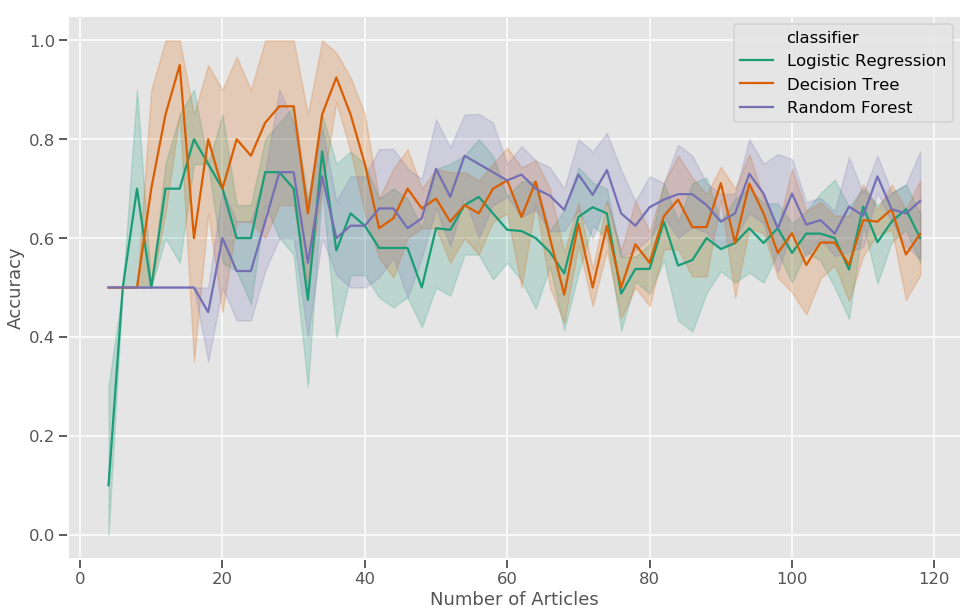

In [200]:
plt.figure(figsize=(16, 10))

fig = sns.lineplot(x= "n", y="accuracy", hue="classifier", data=results_n, markers=True,  palette = "Dark2")
fig.set(xlabel='Number of Articles', ylabel='Accuracy')
plt.show(fig)

## About Interpretability 

In [218]:
X = data.drop(['Fraud','File'], axis=1).set_index(data.File)
Y = data['Fraud']

In [220]:
X = X.loc[:,~X.columns.duplicated()]

In [221]:
# fit the models on the whole dataset 
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


#using the parameters from before 

LR_clf = LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

DT_clf = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

RF_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=True, random_state=42, verbose=0,
            warm_start=False)

LR_clf.fit(X, Y)
DT_clf.fit(X, Y)
RF_clf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

### Logistic Regression 

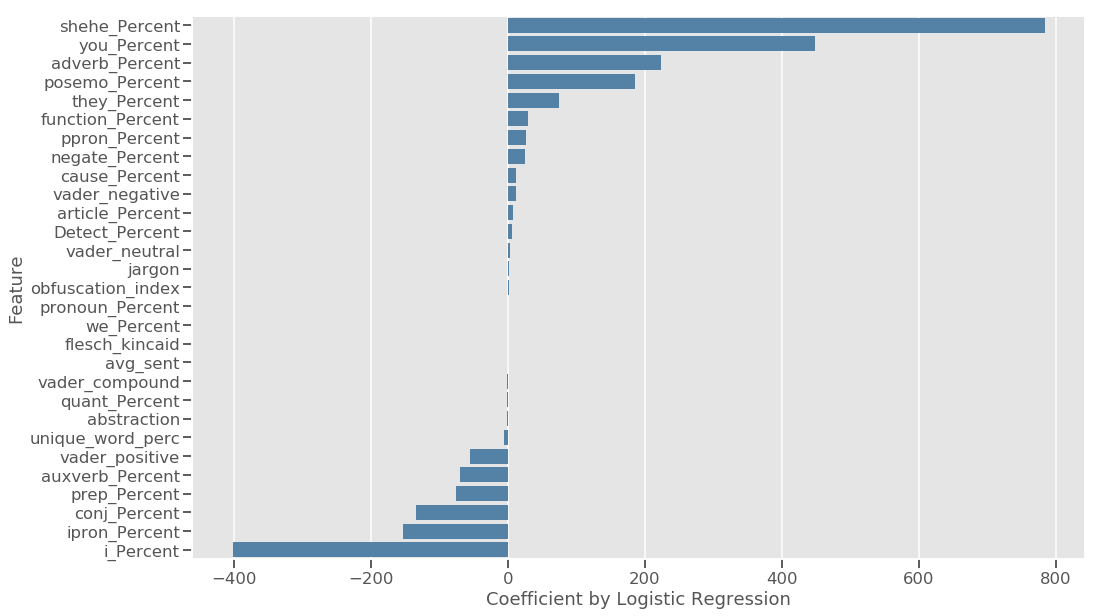

In [222]:
# coefficients of logistic regression 
coeff_df = pd.DataFrame(LR_clf.coef_[0], X.columns, columns=['Coefficient']).reset_index()

coeff_df  = coeff_df .sort_values(by=['Coefficient'], ascending=False)

style.use('ggplot')
sns.set_context('talk')

# make a barplot 
plt.figure(figsize=(16, 10))
fig = sns.barplot(x = "Coefficient", y= "index", data=coeff_df, color = "steelblue")
fig.set(xlabel='Coefficient by Logistic Regression', ylabel='Feature')
plt.show(fig)

### Decision tree 

In [223]:
# Visualize tree
from sklearn.tree import export_graphviz
import graphviz

dot_data = tree.export_graphviz(DT_clf,feature_names=X.columns, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Decision Tree")

'Decision Tree.pdf'

In [225]:
graph.format = 'png'
graph.render('dtree_render',view=True)

'dtree_render.png'

In [216]:
DT_clf.classes_

array([0, 1])

### Random Forest

/Users/lukasmalik/anaconda3/envs/myenv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


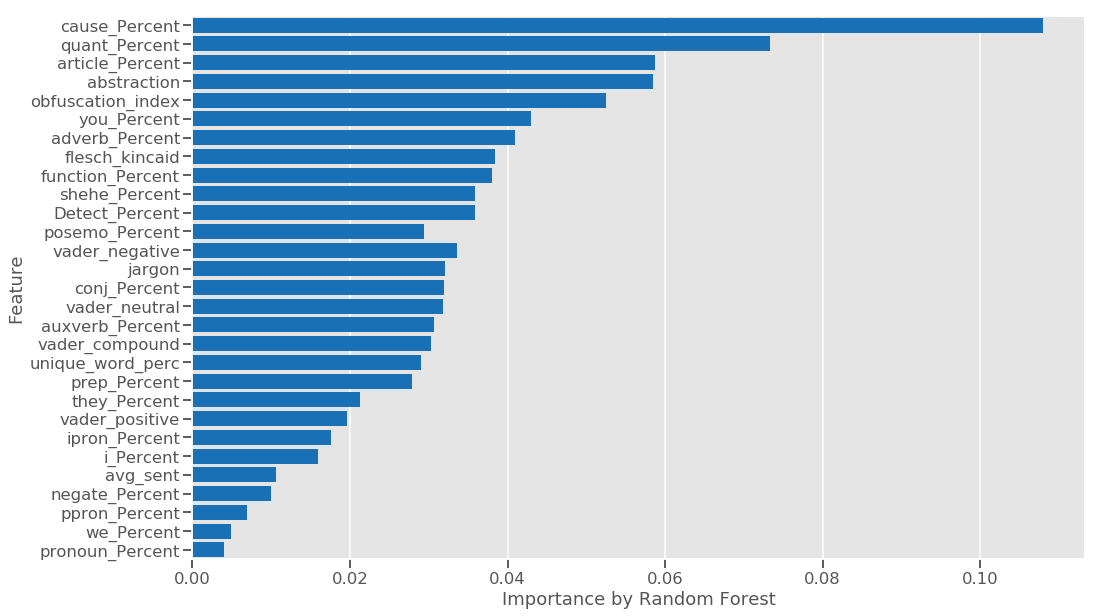

In [180]:
# get feature importance 
rf_importance = pd.DataFrame({'Feature': X.columns,
                              'Importance': RF_clf.feature_importances_,
                              'STD-Error':np.std([tree.feature_importances_ for tree in RF_clf.estimators_], axis=0)
                             })
rf_importance = rf_importance.sort_values(by=['Importance'], ascending=False)
# Plot the feature importances of the forest
style.use('ggplot')
sns.set_context('talk')

# make a barplot 
plt.figure(figsize=(16, 10))
fig = sns.barplot(x = "Importance", y= "Feature",  data=rf_importance, color = "#0073cf", ci = False)
fig.set(xlabel='Importance by Random Forest', ylabel='Feature')
plt.show(fig)

In [178]:
rf_importance

,Feature,Importance,STD-Error
17,cause_Percent,0.107950,0.138688
15,quant_Percent,0.073348,0.101829
9,article_Percent,0.058742,0.103254
27,abstraction,0.058473,0.083320
29,obfuscation_index,0.052470,0.101574
5,you_Percent,0.043023,0.087117
12,adverb_Percent,0.040890,0.072051
21,flesch_kincaid,0.038446,0.090493
0,function_Percent,0.038070,0.075867
6,shehe_Percent,0.035845,0.076049


## Shap 

In [73]:
## HOW TO INTERPRET THE RESULTS USING SHAP 
import shap

# load JS visualization code to notebook
shap.initjs()

In [74]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(RF_clf)
shap_values = explainer.shap_values(X_s)
expected_value = explainer.expected_value
shap_interaction_values = shap.TreeExplainer(RF_clf).shap_interaction_values(X_s)

In [75]:
len(shap_values[0])

120

In [76]:
predictions = pd.DataFrame({'y' : Y.values,
                            'yhat' : RF_clf.predict(X_s),  
                            'yproba' : RF_clf.predict_proba(X_s)[:,1]
                            }, index = X.index,)

In [77]:
predictions.loc['2A.pdf']

y         1.000000
yhat      1.000000
yproba    0.551097
Name: 2A.pdf, dtype: float64

In [80]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value[1], explainer.shap_values(X.loc['2A.pdf'])[1], X.loc['2A.pdf'] , show=True)


In [81]:
# local interpretation
shap.force_plot(explainer.expected_value[1], shap_values[1], X) 

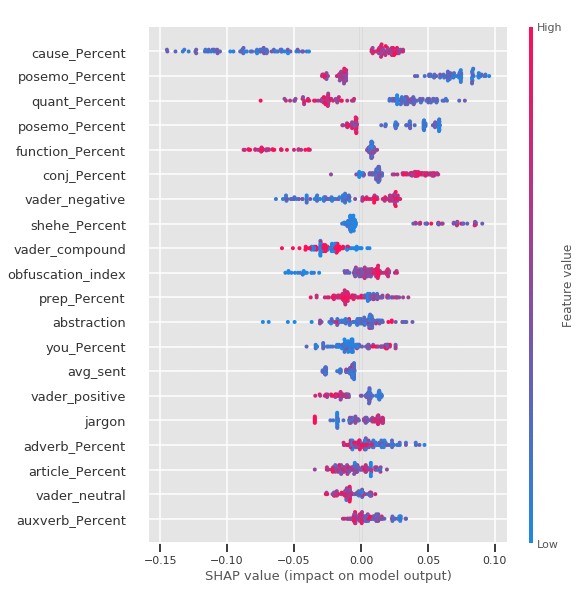

In [82]:
plt.figure(figsize=(16, 10))
shap.summary_plot(shap_values[1], X_s)


<Figure size 1152x720 with 0 Axes>

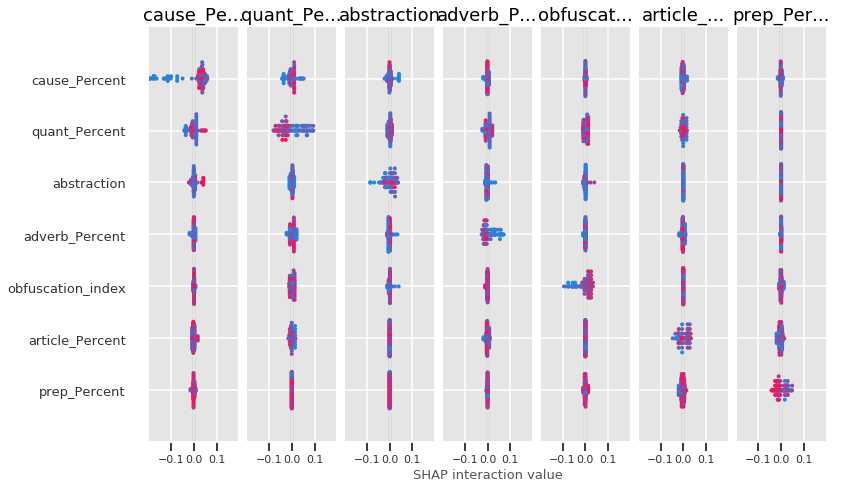

In [94]:
plt.figure(figsize=(16, 10))
shap.summary_plot(shap_interaction_values[1], X_s, max_display=None)

In [46]:
#for f1 in rf_importance['Feature']: 
#    for f2 in rf_importance['Feature']: 
#        if f1 != f2:
#            print(shap.dependence_plot((f1, f2),shap_interaction_values[1], X_s))
#        else: 
#            next

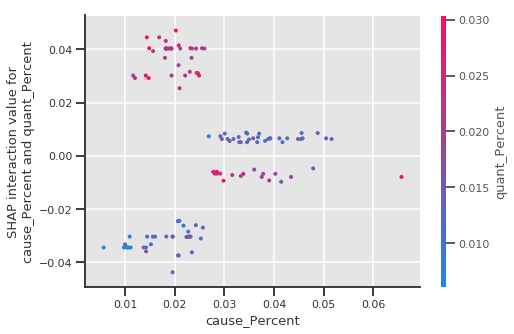

In [84]:
# cause quant 
shap.dependence_plot(
    ("cause_Percent", "quant_Percent"),
    shap_interaction_values[1], X
)

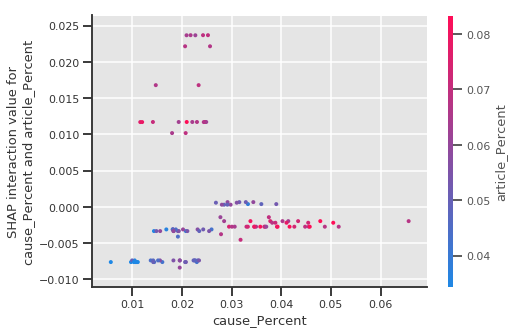

In [83]:
# cause article 
shap.dependence_plot(
    ("cause_Percent", "article_Percent"),
    shap_interaction_values[1], X
)

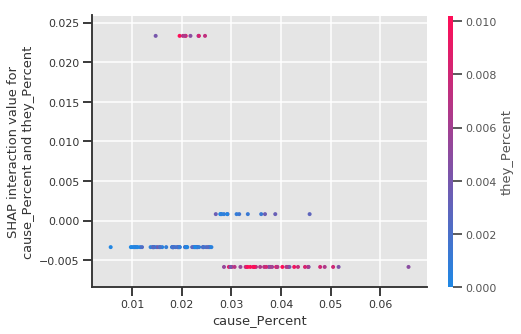

In [85]:
# cause they
shap.dependence_plot(
    ("cause_Percent", "they_Percent"),
    shap_interaction_values[1], X
)

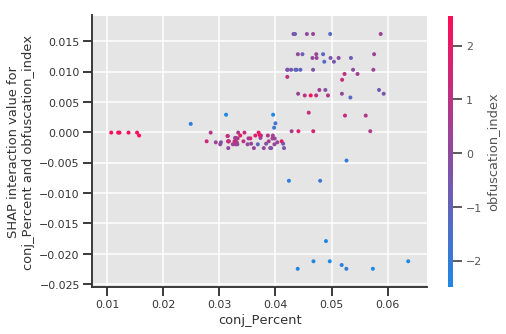

In [88]:
# conj obfuscation index 
shap.dependence_plot(
    ("conj_Percent", "obfuscation_index"),
    shap_interaction_values[1], X
)

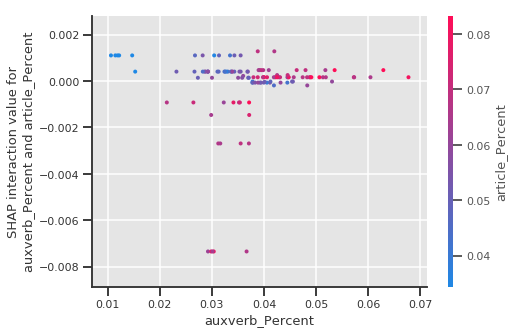

In [90]:
# auxverb article
shap.dependence_plot(
    ("auxverb_Percent", "article_Percent"),
    shap_interaction_values[1], X
)

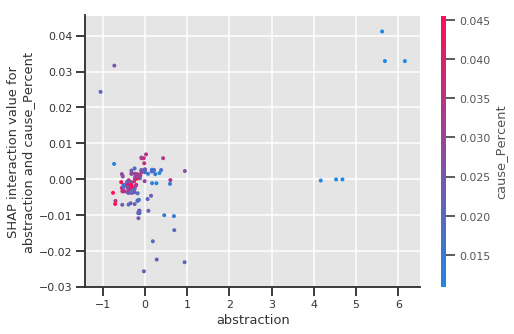

In [92]:
# abstraction cause 
shap.dependence_plot(
    ("abstraction", "cause_Percent"),
    shap_interaction_values[1], X
)

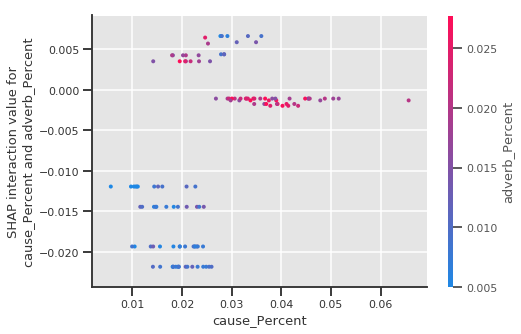

In [94]:
# cause adverb
shap.dependence_plot(
    ("cause_Percent", "adverb_Percent"),
    shap_interaction_values[1], X
)

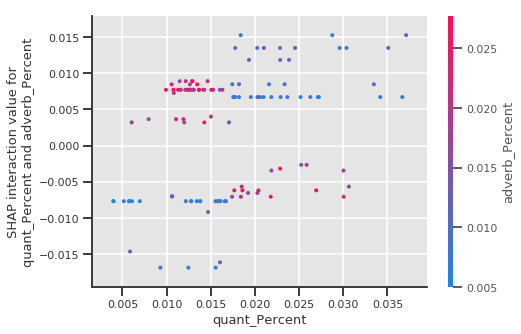

In [95]:
# quant adverb
shap.dependence_plot(
    ("quant_Percent", "adverb_Percent"),
    shap_interaction_values[1], X
)

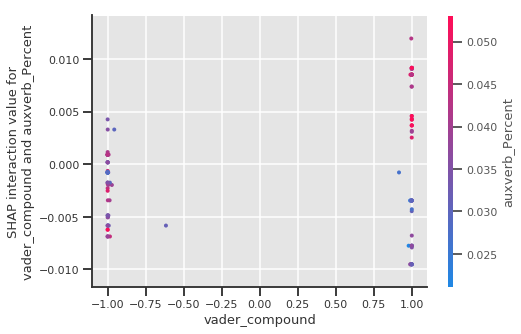

In [93]:
# vader auxverbs 
shap.dependence_plot(
    ("vader_compound", "auxverb_Percent"),
    shap_interaction_values[1], X
)